In [28]:
# read the all_weighted_avg_curves
import pickle
import numpy as np
import xarray as xr
# import numpy as np

data_dir = 'D:/VScode/Last_deglaciation/climo_ana_data'
ds_sat = xr.open_dataset(data_dir + '/ds_GMM_climo_relabeled.nc')

time=ds_sat['age'].values


with open('ens_ana_data/all_weighted_avg_curves_checked.pkl', 'rb') as f:
    all_weighted_avg_curves = pickle.load(f)


In [38]:
all_weighted_avg_curves[0][0].shape

(65,)

Cluster 0: mean CP=21480.0, 5th=21290.0, 95th=21710.0
Cluster 1: mean CP=17230.0, 5th=17100.0, 95th=17300.0
Cluster 2: mean CP=20040.0, 5th=19890.0, 95th=20110.0
Cluster 3: mean CP=18030.0, 5th=17900.0, 95th=18100.0


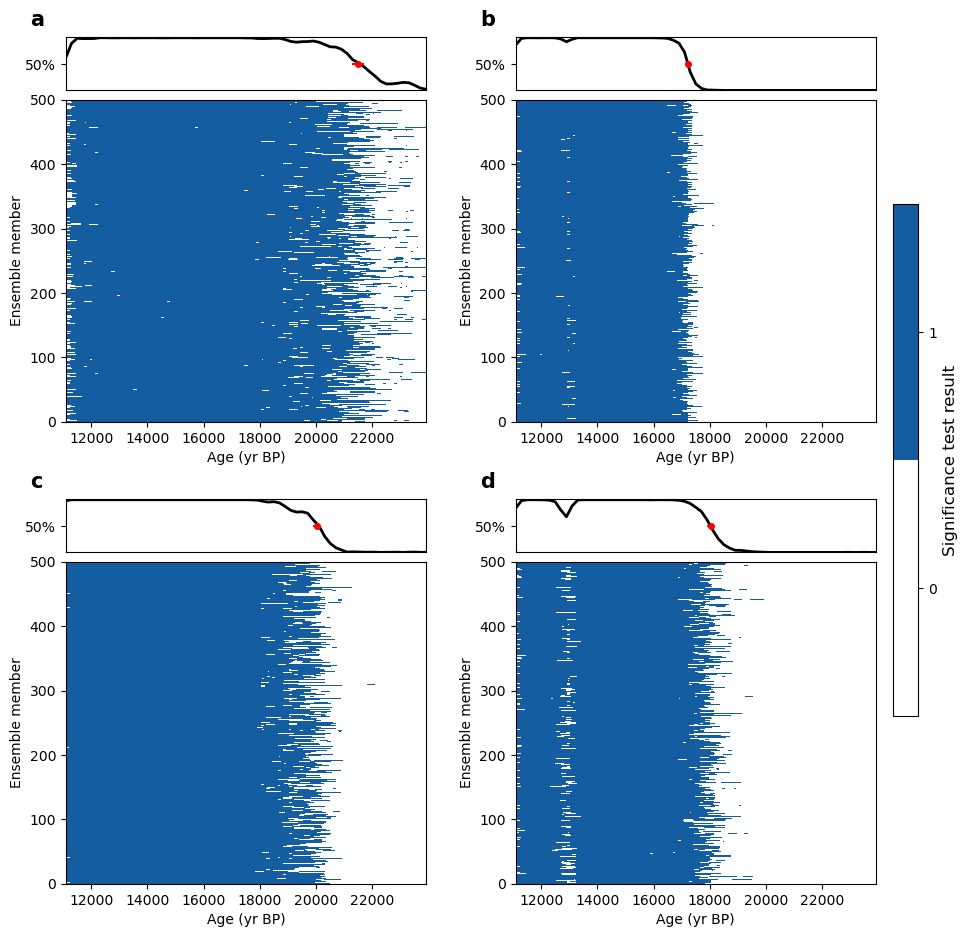

PDF written to outputs/cluster_significance_overview.pdf


In [49]:
# -*- coding: utf-8 -*-
"""
Multi‑cluster change‑point significance analysis and visualisation

Latest tweaks (horizontal spacing + change‑point detection):
1. Increase horizontal gap between the two cluster columns (wspace → 0.25).
2. For every cluster, locate the change‑point where the percentage of ‘1’ values first
   crosses 50 % within 16 – 22 ka BP, estimate a 90 % conf. interval with a simple
   Monte‑Carlo bootstrap (20× resampling, 50 members each) and show:
   • a red ◉ marker at the mean change‑point on the top panel
   • a horizontal error‑bar spanning the 5th–95th percentiles
   • the stats printed to stdout.
"""

import os
import pickle
from pathlib import Path
from typing import List, Tuple, NamedTuple

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_1samp

# --------------------------------------------------------------------------------------
# ------------------------------- data I/O ---------------------------------------------
# --------------------------------------------------------------------------------------

data_dir = Path('D:/VScode/Last_deglaciation/climo_ana_data')
ds_sat = xr.open_dataset(data_dir / 'ds_GMM_climo_relabeled.nc')

time = ds_sat['age'].values  # (n_time,)

with open('ens_ana_data/all_weighted_avg_curves_checked.pkl', 'rb') as f:
    all_weighted_avg_curves = pickle.load(f)  # list[dict]

# --------------------------------------------------------------------------------------
# ----------------------------- helper functions ---------------------------------------
# --------------------------------------------------------------------------------------

class CPStats(NamedTuple):
    mean: float
    low: float
    high: float


def smooth_gaussian(data: np.ndarray, sigma: float) -> np.ndarray:
    return gaussian_filter1d(data, sigma=sigma)


def analyse_significance(time_series_data: List[np.ndarray], sigmas: List[int]) -> List[np.ndarray]:
    sig_arrays: List[np.ndarray] = []
    for series in time_series_data:
        derivs = [np.gradient(smooth_gaussian(series, s)) * -1 for s in sigmas]
        deriv_matrix = np.array(derivs).T
        sig_arr = np.zeros_like(series)
        for i in range(len(sig_arr)):
            _, p = ttest_1samp(deriv_matrix[i], 0)
            if p < 0.05:
                m = np.mean(deriv_matrix[i])
                sig_arr[i] = -1 if m < 0 else 1 if m > 0 else 0
        sig_arrays.append(sig_arr)
    return sig_arrays


def bootstrap_change_point(sig_arrays: List[np.ndarray], time_axis: np.ndarray) -> CPStats:
    sig_matrix = np.array(sig_arrays)
    picks: List[float] = []
    idx_range = np.where((time_axis >= 16_000) & (time_axis <= 22_000))[0]
    for _ in range(20):
        sel = np.random.choice(sig_matrix.shape[0], 50, replace=True)
        mean_sel = np.mean(sig_matrix[sel] == 1, axis=0) * 100
        if idx_range.size:
            idx50 = idx_range[np.argmin(np.abs(mean_sel[idx_range] - 50))]
            picks.append(time_axis[idx50])
    picks = np.asarray(picks)
    return CPStats(np.mean(picks), np.percentile(picks, 5), np.percentile(picks, 95))


def plot_cluster(ax_top, ax_bottom, sig_arrays: List[np.ndarray], time_range: Tuple[float, float]):
    percentage = np.mean(np.array(sig_arrays) == 1, axis=0) * 100
    t_axis = np.linspace(*time_range, percentage.size)

    cp_stats = bootstrap_change_point(sig_arrays, t_axis)

    # --- top axis
    ax_top.plot(t_axis, percentage, lw=2, color='black')
    ax_top.errorbar(cp_stats.mean, 50, xerr=[[cp_stats.mean - cp_stats.low], [cp_stats.high - cp_stats.mean]], fmt='ro', ms=4)
    ax_top.set_xlim(time_range)
    ax_top.set_ylim(0, 102)
    ax_top.set_yticks([50])
    ax_top.set_yticklabels(['50%'])
    ax_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # --- heat‑map
    im = ax_bottom.imshow(
        np.array(sig_arrays),
        aspect='auto',
        cmap=ListedColormap(["white", "#145da0"]),
        extent=[*time_range, 0, len(sig_arrays)],
        vmin=0,
        vmax=1,
    )
    ax_bottom.set_xlabel('Age (yr BP)')
    ax_bottom.set_ylabel('Ensemble member')
    return im, cp_stats

# --------------------------------------------------------------------------------------
# -------------------------- main analysis & plotting ----------------------------------
# --------------------------------------------------------------------------------------

sigmas = list(range(1, 20))
clusters = range(4)
cluster_results: List[List[np.ndarray]] = []

for k in clusters:
    curves_k = []
    for d in all_weighted_avg_curves:
        curves_k.append(d.get(k, d.get(str(k))))
    # normalise 18.1–21 ka
    for i, ts in enumerate(curves_k):
        curves_k[i] = ts - ts[35:55].mean()
    cluster_results.append(analyse_significance(curves_k, sigmas))

# ---------- figure ----------
fig = plt.figure(figsize=(11, 11), dpi=100)
outer_gs = GridSpec(2, 2, figure=fig, wspace=0.25, hspace=0.2)  # wider column gap
ims = []
panel_labels = ['a', 'b', 'c', 'd']

for idx, (sig_arrs, k) in enumerate(zip(cluster_results, clusters)):
    r, c = divmod(idx, 2)
    inner_gs = outer_gs[r, c].subgridspec(2, 1, height_ratios=[1, 6], hspace=0.05)
    ax_top = fig.add_subplot(inner_gs[0])
    ax_bot = fig.add_subplot(inner_gs[1])

    im, cp = plot_cluster(ax_top, ax_bot, sig_arrs, (time[0], time[-1]))
    ims.append(im)

    # label and title
    ax_top.text(-0.1, 1.5, panel_labels[idx], transform=ax_top.transAxes, fontsize=15, fontweight='bold', va='top')
    # ax_top.set_title(f'Cluster {k} — CP: {cp.mean:0.0f} (⁵ᵗʰ={cp.low:0.0f}, ⁹⁵ᵗʰ={cp.high:0.0f}) yr BP', loc='left', fontsize=9)
    print(f'Cluster {k}: mean CP={cp.mean:.1f}, 5th={cp.low:.1f}, 95th={cp.high:.1f}')

# vertical colour‑bar on the right
cbar = fig.colorbar(ims[0], ax=fig.get_axes(), orientation='vertical', fraction=0.03, pad=0.02, ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['0', '1'])
cbar.set_label('Significance test result', fontsize=12)

# fig.suptitle('Change‑point significance across four GMM clusters', fontsize=14)

# show then save
plt.show()

out_dir = Path('outputs'); out_dir.mkdir(exist_ok=True)
fig.savefig(out_dir / 'figureS4.pdf', bbox_inches='tight')
print('PDF written to outputs/cluster_significance_overview.pdf')


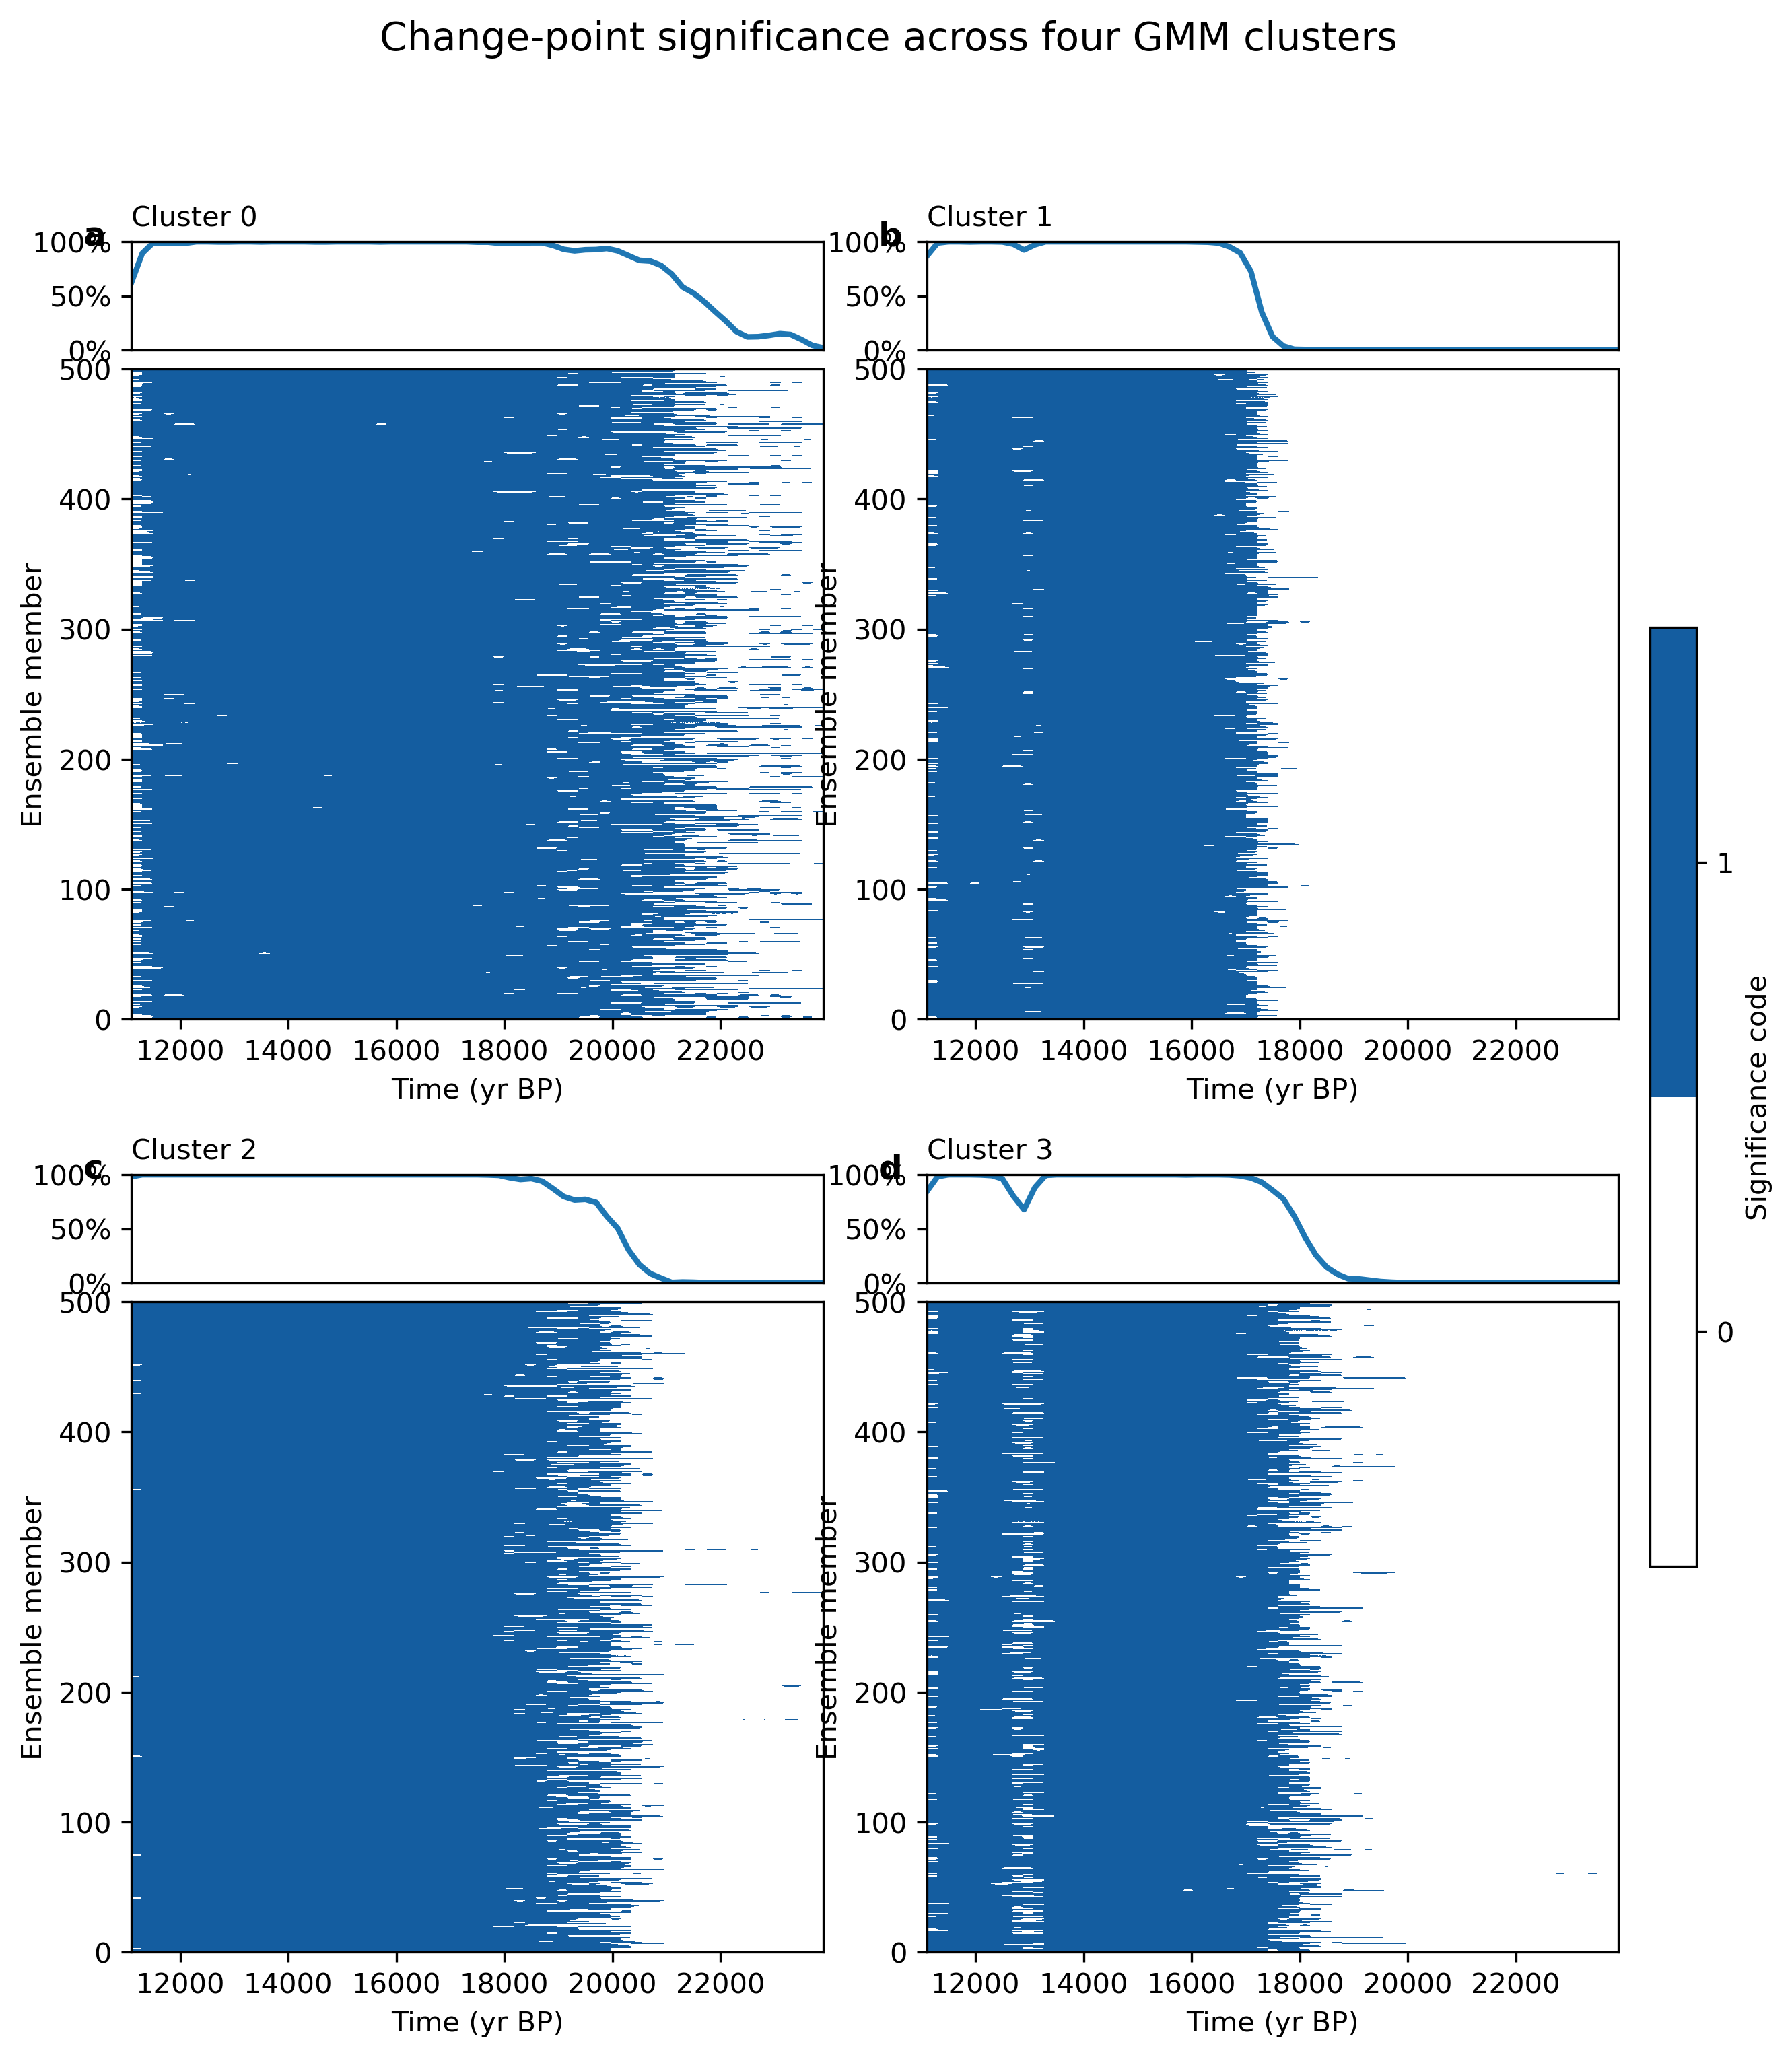

Figure saved to: D:\VScode\Last_deglaciation\outputs\cluster_significance_overview.pdf


In [40]:
# -*- coding: utf-8 -*-
"""
Multi-cluster change-point significance analysis and visualisation

Incremental changes requested by the user (24 Apr 2025):
1. Two-tone **blue ↔ white** colour-map for the significance heat-maps.
2. Make the overall figure a bit higher (⬆︎ height → 11 in instead of 8 in).
3. Display (`plt.show()`) the figure *before* saving it.
4. Add panel labels **a–d** to the top-left of each cluster.
5. Move the shared colour-bar to the **right‐hand side**, vertical orientation.
"""

import os
import pickle
from pathlib import Path
from typing import List, Tuple

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_1samp

# --------------------------------------------------------------------------------------
# ------------------------------- data I/O ---------------------------------------------
# --------------------------------------------------------------------------------------

data_dir = Path('D:/VScode/Last_deglaciation/climo_ana_data')
ds_sat = xr.open_dataset(data_dir / 'ds_GMM_climo_relabeled.nc')

time = ds_sat['age'].values  # (n_time,)

with open('ens_ana_data/all_weighted_avg_curves_checked.pkl', 'rb') as f:
    all_weighted_avg_curves = pickle.load(f)  # list[dict]

# --------------------------------------------------------------------------------------
# ----------------------------- helper functions ---------------------------------------
# --------------------------------------------------------------------------------------

def smooth_gaussian(data: np.ndarray, sigma: float) -> np.ndarray:
    """Gaussian smoothing helper"""
    return gaussian_filter1d(data, sigma=sigma)


def analyse_significance(time_series_data: List[np.ndarray], sigmas: List[int]) -> List[np.ndarray]:
    """Return list[significance_array] for an ensemble of time series."""
    all_significance_arrays: List[np.ndarray] = []

    for series in time_series_data:
        deriv_matrix: List[np.ndarray] = []
        for s in sigmas:
            deriv_matrix.append(np.gradient(smooth_gaussian(series, s)) * -1)
        deriv_matrix = np.array(deriv_matrix).T  # shape (n_time, n_sigmas)

        sig_arr = np.zeros_like(series)
        for i in range(len(sig_arr)):
            _, p = ttest_1samp(deriv_matrix[i], 0)
            if p < 0.05:
                m = np.mean(deriv_matrix[i])
                sig_arr[i] = -1 if m < 0 else 1 if m > 0 else 0
        all_significance_arrays.append(sig_arr)
    return all_significance_arrays


def plot_cluster(ax_top, ax_bottom, sig_arrays: List[np.ndarray], time_range: Tuple[float, float]):
    """Plot percentage curve + heat-map on the provided pair of axes."""

    percentage = np.mean(np.array(sig_arrays) == 1, axis=0) * 100.0
    t_axis = np.linspace(*time_range, percentage.size)
    ax_top.plot(t_axis, percentage, lw=2)
    ax_top.set_xlim(time_range)
    ax_top.set_ylim(0, 100)
    ax_top.set_yticks([0, 50, 100])
    ax_top.set_yticklabels(['0%', '50%', '100%'])
    ax_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    im = ax_bottom.imshow(
        np.array(sig_arrays),
        aspect='auto',
        cmap=ListedColormap(["white", "#145da0"]),  # white for 0, deep blue for 1
        extent=[*time_range, 0, len(sig_arrays)],
        vmin=0,
        vmax=1,
    )
    ax_bottom.set_xlabel('Time (yr BP)')
    ax_bottom.set_ylabel('Ensemble member')
    return im

# --------------------------------------------------------------------------------------
# -------------------------- main analysis & plotting ----------------------------------
# --------------------------------------------------------------------------------------

sigmas = list(range(1, 20))
clusters = range(4)
cluster_results: List[List[np.ndarray]] = []

for k in clusters:
    curves_k: List[np.ndarray] = []
    for curves_dict in all_weighted_avg_curves:
        if k in curves_dict:
            curves_k.append(curves_dict[k])
        elif str(k) in curves_dict:
            curves_k.append(curves_dict[str(k)])
        else:
            raise KeyError(f"Cluster key {k} missing in one of the dictionaries.")

    # normalise: subtract mean over 18 100–21 000 yr BP (indices 35–54)
    for i, ts in enumerate(curves_k):
        baseline = ts[35:55].mean()
        curves_k[i] = ts - baseline

    cluster_results.append(analyse_significance(curves_k, sigmas))

# ---------- figure ----------
fig = plt.figure(figsize=(10, 11), dpi=300)
outer_gs = GridSpec(2, 2, figure=fig, wspace=0.15, hspace=0.2)
ims = []
panel_labels = ['a', 'b', 'c', 'd']

for idx, (cluster_sig, k) in enumerate(zip(cluster_results, clusters)):
    r, c = divmod(idx, 2)
    inner_gs = outer_gs[r, c].subgridspec(2, 1, height_ratios=[1, 6], hspace=0.05)
    ax_top = fig.add_subplot(inner_gs[0])
    ax_bot = fig.add_subplot(inner_gs[1])
    im = plot_cluster(ax_top, ax_bot, cluster_sig, (time[0], time[-1]))
    ims.append(im)

    # panel label (top-left of the top axis)
    ax_top.text(-0.07, 1.2, panel_labels[idx], transform=ax_top.transAxes, fontsize=12, fontweight='bold', va='top')
    ax_top.set_title(f'Cluster {k}', loc='left', fontsize=10)

# ------------------------------------------------------
# vertical colour-bar on the right
# ------------------------------------------------------

cbar = fig.colorbar(
    ims[0],
    ax=fig.get_axes(),
    orientation='vertical',
    fraction=0.03,
    pad=0.02,
    ticks=[0.25, 0.75],
)
cbar.ax.set_yticklabels(['0', '1'])
cbar.set_label('Significance code')

fig.suptitle('Change-point significance across four GMM clusters', fontsize=14)

# --------------------------------------------------------------------------------------
# ------------------------ display *then* save -----------------------------------------
# --------------------------------------------------------------------------------------

plt.show()  # show first

output_dir = Path('outputs')
output_dir.mkdir(exist_ok=True)
output_path = output_dir / 'cluster_significance_overview.pdf'
fig.savefig(output_path, bbox_inches='tight')
print(f'Figure saved to: {output_path.resolve()}')


In [39]:
# -*- coding: utf-8 -*-
"""
Multi‑cluster change‑point significance analysis and visualisation

Fixes:
• Remove PEP‑585 style type hints that break on Python < 3.9 (use typing.List instead).
• Handle the true structure of *all_weighted_avg_curves* (list of 500 dicts with
  string or int keys ‘0’–‘3’).
"""

import os
import pickle
from pathlib import Path
from typing import List, Tuple

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_1samp

# --------------------------------------------------------------------------------------
# ------------------------------- data I/O ---------------------------------------------
# --------------------------------------------------------------------------------------

data_dir = Path('D:/VScode/Last_deglaciation/climo_ana_data')
ds_sat = xr.open_dataset(data_dir / 'ds_GMM_climo_relabeled.nc')

time = ds_sat['age'].values  # (n_time,)

with open('ens_ana_data/all_weighted_avg_curves_checked.pkl', 'rb') as f:
    all_weighted_avg_curves = pickle.load(f)  # list[dict]

# --------------------------------------------------------------------------------------
# ----------------------------- helper functions ---------------------------------------
# --------------------------------------------------------------------------------------

def smooth_gaussian(data: np.ndarray, sigma: float) -> np.ndarray:
    """Gaussian smoothing helper"""
    return gaussian_filter1d(data, sigma=sigma)


def analyse_significance(time_series_data: List[np.ndarray], sigmas: List[int]) -> List[np.ndarray]:
    """Return list[significance_array] for an ensemble of time series."""
    all_significance_arrays: List[np.ndarray] = []

    for series in time_series_data:
        deriv_matrix: List[np.ndarray] = []
        for s in sigmas:
            deriv_matrix.append(np.gradient(smooth_gaussian(series, s)) * -1)
        deriv_matrix = np.array(deriv_matrix).T  # shape (n_time, n_sigmas)

        sig_arr = np.zeros_like(series)
        for i in range(len(sig_arr)):
            _, p = ttest_1samp(deriv_matrix[i], 0)
            if p < 0.05:
                m = np.mean(deriv_matrix[i])
                sig_arr[i] = -1 if m < 0 else 1 if m > 0 else 0
        all_significance_arrays.append(sig_arr)
    return all_significance_arrays


def plot_cluster(ax_top, ax_bottom, sig_arrays: List[np.ndarray], time_range: Tuple[float, float]):
    """Plot percentage curve + heat‑map on the provided pair of axes."""

    percentage = np.mean(np.array(sig_arrays) == 1, axis=0) * 100.0
    t_axis = np.linspace(*time_range, percentage.size)
    ax_top.plot(t_axis, percentage, lw=2)
    ax_top.set_xlim(time_range)
    ax_top.set_ylim(0, 100)
    ax_top.set_yticks([0, 50, 100])
    ax_top.set_yticklabels(['0%', '50%', '100%'])
    ax_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    im = ax_bottom.imshow(
        np.array(sig_arrays),
        aspect='auto',
        cmap=ListedColormap(["#0d88c2", "#f1a340"]),  # nicer blue / orange tones
        extent=[*time_range, 0, len(sig_arrays)],
        vmin=0,
        vmax=1,
    )
    ax_bottom.set_xlabel('Time (yr BP)')
    ax_bottom.set_ylabel('Ensemble member')
    return im

# --------------------------------------------------------------------------------------
# -------------------------- main analysis & plotting ----------------------------------
# --------------------------------------------------------------------------------------

sigmas = list(range(1, 20))
clusters = range(4)
cluster_results: List[List[np.ndarray]] = []

for k in clusters:
    curves_k: List[np.ndarray] = []
    for curves_dict in all_weighted_avg_curves:
        if k in curves_dict:
            curves_k.append(curves_dict[k])
        elif str(k) in curves_dict:
            curves_k.append(curves_dict[str(k)])
        else:
            raise KeyError(f"Cluster key {k} missing in one of the dictionaries.")

    # normalise: subtract mean over 18 100–21 000 yr BP (indices 35–54)
    for i, ts in enumerate(curves_k):
        baseline = ts[35:55].mean()
        curves_k[i] = ts - baseline

    cluster_results.append(analyse_significance(curves_k, sigmas))

# ---------- figure ----------
fig = plt.figure(figsize=(10, 8), dpi=300)
outer_gs = GridSpec(2, 2, figure=fig, wspace=0.15, hspace=0.2)
ims = []

for idx, (cluster_sig, k) in enumerate(zip(cluster_results, clusters)):
    r, c = divmod(idx, 2)
    inner_gs = outer_gs[r, c].subgridspec(2, 1, height_ratios=[1, 6], hspace=0.05)
    ax_top = fig.add_subplot(inner_gs[0])
    ax_bot = fig.add_subplot(inner_gs[1])
    im = plot_cluster(ax_top, ax_bot, cluster_sig, (time[0], time[-1]))
    ims.append(im)
    ax_top.set_title(f'Cluster {k}', loc='left', fontsize=10)

# common colour‑bar
cbar = fig.colorbar(ims[0], ax=fig.get_axes(), orientation='horizontal', fraction=0.035, pad=0.05, ticks=[0.25, 0.75])
cbar.ax.set_xticklabels(['0', '1'])
cbar.set_label('Significance code')

fig.suptitle('Change‑point significance across four GMM clusters', fontsize=14)

# --------------------------------------------------------------------------------------
# ------------------------ save to PDF (outputs/) --------------------------------------
# --------------------------------------------------------------------------------------

output_dir = Path('outputs')
output_dir.mkdir(exist_ok=True)
output_path = output_dir / 'cluster_significance_overview.pdf'
fig.savefig(output_path, bbox_inches='tight')
print(f'Figure saved to: {output_path.resolve()}')

plt.close(fig)


Figure saved to: D:\VScode\Last_deglaciation\outputs\cluster_significance_overview.pdf


In [ ]:
# read the all_weighted_avg_curves
import pickle
import numpy as np
import xarray as xr
# import numpy as np

data_dir = 'D:/VScode/Last_deglaciation/climo_ana_data'
ds_sat = xr.open_dataset(data_dir + '/ds_GMM_climo_relabeled.nc')

time=ds_sat['age'].values


with open('ens_ana_data/all_weighted_avg_curves_checked.pkl', 'rb') as f:
    all_weighted_avg_curves = pickle.load(f)


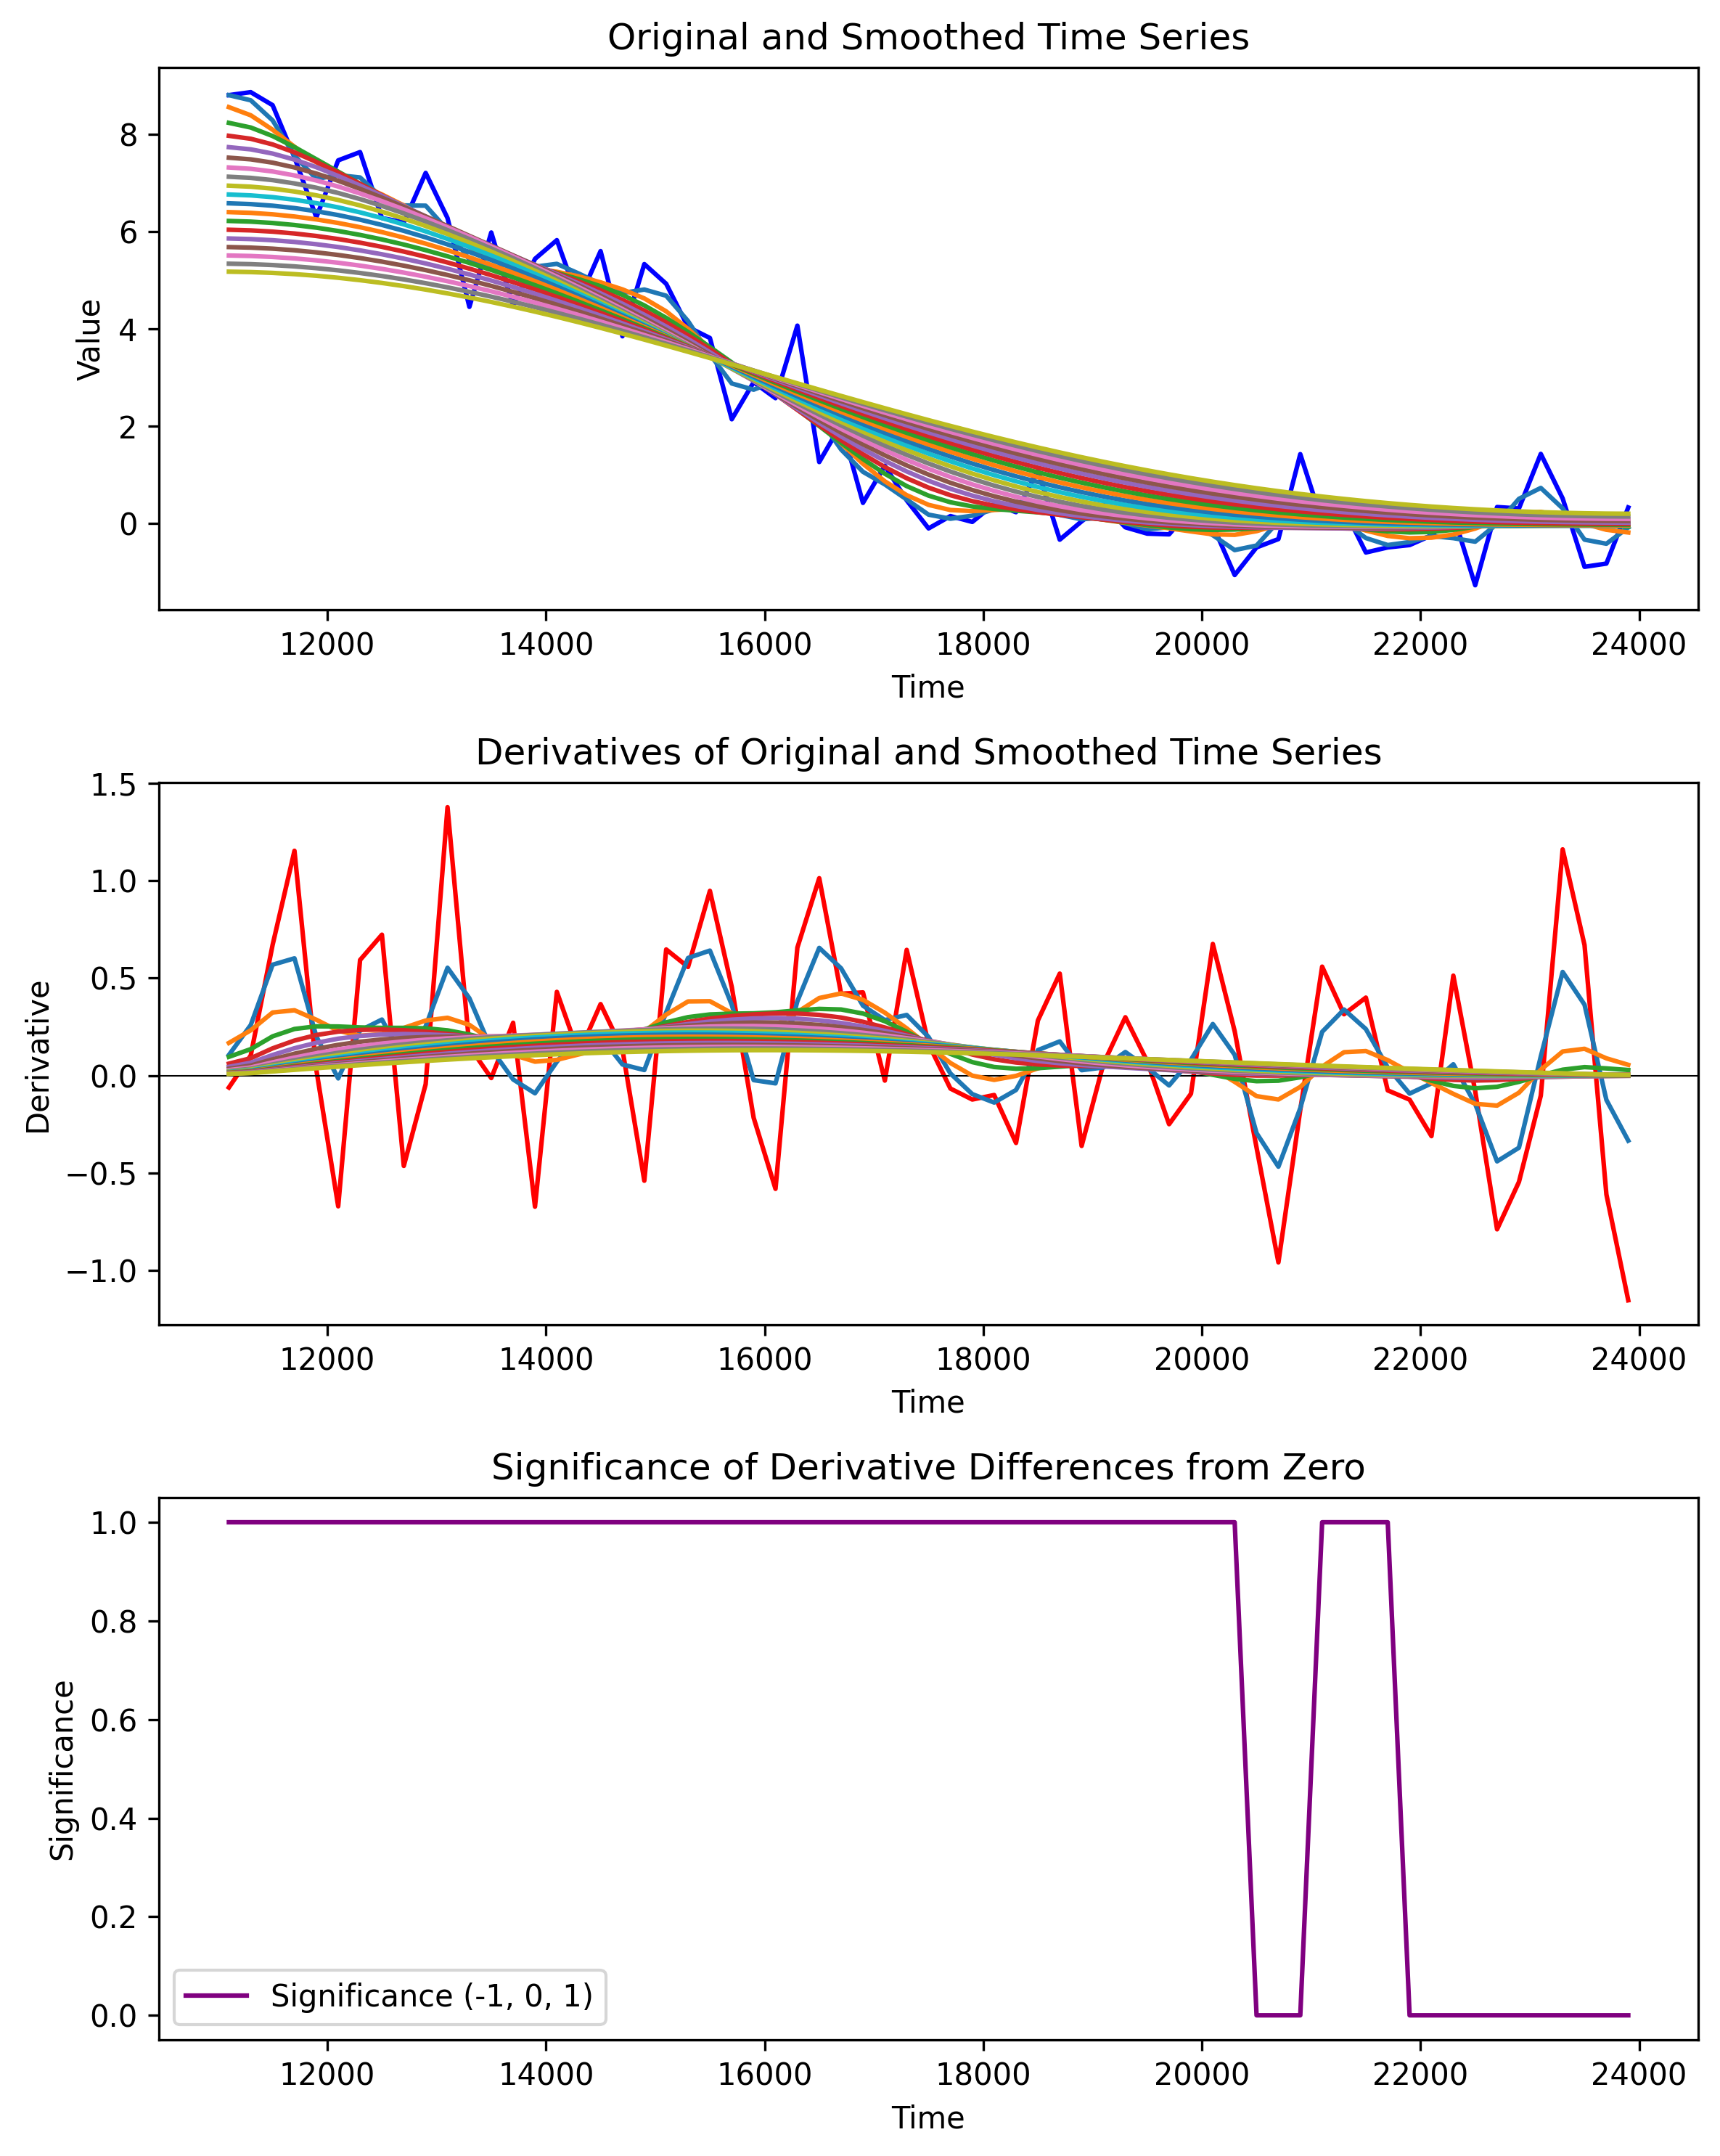

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_1samp

def smooth_gaussian(data, sigma):
    """
    Smooth a time series using a Gaussian kernel.
    
    Parameters:
        data (array-like): The time series data to be smoothed.
        sigma (float): The standard deviation for Gaussian kernel, determines the amount of smoothing.
        
    Returns:
        smoothed_data (ndarray): The smoothed time series data.
    """
    smoothed_data = gaussian_filter1d(data, sigma=sigma)
    return smoothed_data

time_series = weighted_avg_curves_k[0]
# Prepare to store derivatives for significance testing
derivatives_matrix = []

# Define sigma values for Gaussian smoothing
# sigmas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# create a sigma list from 1 to 64 with step 2
sigmas = list(range(1, 20, 1))

# Plot original time series and derivatives
plt.figure(figsize=(8, 10),dpi=300)

# Plot original time series
plt.subplot(3, 1, 1)
plt.plot(time, time_series, label='Original Time Series', color='blue')

# Plot smoothed time series for each sigma
for sigma in sigmas:
    smoothed_data = smooth_gaussian(time_series, sigma)
    plt.plot(time, smoothed_data, label=f'Smoothed (Sigma {sigma})')

plt.title('Original and Smoothed Time Series')
plt.xlabel('Time')
plt.ylabel('Value')


# Calculate derivative of original time series
original_derivative = np.gradient(time_series)*-1
# derivatives_matrix.append(original_derivative)

# Plot derivatives
plt.subplot(3, 1, 2)
plt.plot(time, original_derivative, label='Derivative (Original)', color='red')
plt.axhline(0, color='black', linewidth=0.5)

for sigma in sigmas:
    smoothed_data = smooth_gaussian(time_series, sigma)
    derivative = np.gradient(smoothed_data)*-1
    plt.plot(time, derivative, label=f'Derivative (Sigma {sigma})')
    derivatives_matrix.append(derivative)

plt.title('Derivatives of Original and Smoothed Time Series')
plt.xlabel('Time')
plt.ylabel('Derivative')
# plt.legend()

# Significance test for derivatives and create an array of significant values
significance_array = np.zeros_like(time_series)

# Transpose to get time-wise data (each row represents derivatives at a time point)
derivatives_matrix = np.array(derivatives_matrix).T

# Perform t-tests on each time point's derivatives
for i in range(len(derivatives_matrix)):
    _, p_value = ttest_1samp(derivatives_matrix[i], 0)
    if p_value < 0.05:
        mean_derivative = np.mean(derivatives_matrix[i])
        if mean_derivative < 0:
            significance_array[i] = -1
        elif mean_derivative > 0:
            significance_array[i] = 1

# Plot significance
plt.subplot(3, 1, 3)
plt.plot(time,significance_array, label='Significance (-1, 0, 1)', color='purple')
plt.title('Significance of Derivative Differences from Zero')
plt.xlabel('Time')
plt.ylabel('Significance')
plt.legend()

plt.tight_layout()
plt.show()


# Calculate the significance of the slope for ensemble data

In [6]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_1samp

def smooth_gaussian(data, sigma):
    """
    Smooth a time series using a Gaussian kernel.
    
    Parameters:
        data (array-like): The time series data to be smoothed.
        sigma (float): The standard deviation for Gaussian kernel, determines the amount of smoothing.
        
    Returns:
        ndarray: The smoothed time series data.
    """
    smoothed_data = gaussian_filter1d(data, sigma=sigma)
    return smoothed_data

def analyze_significance(time_series_data, sigmas):
    """
    Analyze the significance of derivatives across multiple time series data with Gaussian smoothing.
    
    Parameters:
        time_series_data (list of ndarray): A list containing multiple time series data.
        sigmas (list of int): A list of sigma values for Gaussian smoothing.
    
    Returns:
        list of ndarray: A list of arrays where each array contains the significance coding (-1, 0, 1) for each time point.
    """
    all_significance_arrays = []
    
    for time_series in time_series_data:
        derivatives_matrix = []
        
        for sigma in sigmas:
            smoothed_data = smooth_gaussian(time_series, sigma)
            derivative = np.gradient(smoothed_data) * -1
            derivatives_matrix.append(derivative)
        
        derivatives_matrix = np.array(derivatives_matrix).T
        significance_array = np.zeros_like(time_series)
        
        for i in range(len(derivatives_matrix)):
            _, p_value = ttest_1samp(derivatives_matrix[i], 0)
            if p_value < 0.05:
                mean_derivative = np.mean(derivatives_matrix[i])
                if mean_derivative < 0:
                    significance_array[i] = -1
                elif mean_derivative > 0:
                    significance_array[i] = 1
        
        all_significance_arrays.append(significance_array)
    
    return all_significance_arrays



import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap



import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_significance_map_with_curve(significance_arrays, time_range, ensemble_count, figsize=(6, 6), dpi=300, if_colorbar=True):
    """
    Plots a 2D color map of significance results for multiple time series and a separate subplot showing the percentage of data
    that got a significant level of 1.
    
    Parameters:
        significance_arrays (list of ndarray): A list of arrays containing significance values for each time series.
        time_range (tuple): A tuple (min_time, max_time) defining the extent of the time dimension.
        ensemble_count (int): The number of time series (ensemble members).
        figsize (tuple): The dimensions of the figure to be plotted.
        dpi (int): The resolution of the figure in dots per inch.
    """
    # Calculate the proportion of '1' values for each time point
    percentage_significant = np.mean(np.array(significance_arrays) == 1, axis=0) * 100


    # Setup the figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, dpi=dpi, gridspec_kw={'height_ratios': [1, 6]})

    # Plot the percentage curve
    time_axis = np.linspace(time_range[0], time_range[1], len(percentage_significant))
    ax1.plot(time_axis, percentage_significant, color='blue', linewidth=2)
    # # for time between 16000 to 22000, find the time where y is most close to 50 and plot a red dot
    # time_50 = time_axis[np.argmin(np.abs(percentage_significant - 50))]
    # ax1.plot(time_50, 50, 'ro')

    # Limiting the search for time_50 between 16000 and 22000
    # limited_indices = np.where((time_axis >= 16000) & (time_axis <= 22000))[0]
    # if limited_indices.size > 0:
    #     index_50 = limited_indices[np.argmin(np.abs(percentage_significant[limited_indices] - 50))]
    #     ax1.plot(time_axis[index_50], percentage_significant[index_50], 'ro', label='50% Significance (16000-22000)')
        # ax1.legend()

    # randomly select 10 records from significance_arrays and claculate the mean of the selected records, repead this for 10 times and find the time_50
    significance_matrix = np.array(significance_arrays)
    time_50_mc = []
    for i in range(20):
        selected_indices = np.random.choice(significance_matrix.shape[0], 50, replace=True)
        selected_records = significance_matrix[selected_indices, :]
        mean_selected_records = np.mean(selected_records == 1, axis=0) * 100
        limited_mc_indices = np.where((time_axis >= 16000) & (time_axis <= 22000))[0]
        if limited_mc_indices.size > 0:
            index_50_mc = limited_mc_indices[np.argmin(np.abs(mean_selected_records[limited_mc_indices] - 50))]
            time_50_mc.append(time_axis[index_50_mc])
            # ax1.plot(time_axis[index_50_mc], mean_selected_records[index_50_mc], 'gx')


    # for time_50_mc calculate the 5th and 95th percentile, plot eror bar at time_50 with xerr=[5th, 95th]
    time_50_mc = np.array(time_50_mc)
    if time_50_mc.size > 0:
        time_50_mc_5th = np.percentile(time_50_mc, 5)
        time_50_mc_95th = np.percentile(time_50_mc, 95)
        ax1.errorbar(np.mean(time_50_mc), 50, xerr=[[np.mean(time_50_mc) - time_50_mc_5th], [time_50_mc_95th - np.mean(time_50_mc)]], fmt='ro', markersize=3, label='50% Significance (MC)')

    # print the mean and 5th and 95th percentile of time_50_mc
    print(f'Mean of time_50_mc: {np.mean(time_50_mc)}')
    print(f'5th percentile of time_50_mc: {time_50_mc_5th}')
    print(f'95th percentile of time_50_mc: {time_50_mc_95th}')

    # set x lim
    ax1.set_xlim(time_range)
    # show x ticks and xticklabels on top instead of bottom
    # ax1.xaxis.tick_top()
    # # turn off the xticklabels on top
    # ax1.xaxis.set_tick_params(labeltop=False)
    # # set y

    # set x and y ticks and ticklaabels to invisible
    ax1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False)
    # ax1.tick_params(axis='y', which='both', right=True, left=False, labelleft=False)
    # set y tick labels
    ax1.set_yticks([0, 100])
    ax1.set_yticklabels(['0%', '100%'])

    
    # ax1.set_ylabel('Percentage (%)')
    # ax1.set_title('Percentage of Significance Level 1')
    # ax1.grid(True)

    # Plot the 2D color map
    colors = ['steelblue', 'lightcoral']  # Green for 0, orange for 1
    cmap = ListedColormap(colors)
    img = ax2.imshow(np.array(significance_arrays), aspect='auto', cmap=cmap, extent=[time_range[0], time_range[1], 0, ensemble_count], vmin=0, vmax=1)
    if if_colorbar:
        cbar = plt.colorbar(img, ax=ax2, ticks=[0.25, 0.75], label='Significance (0, 1)')
        cbar.set_ticklabels(['0', '1'])
    ax2.set_xlabel('Time (yr BP)')
    ax2.set_ylabel('Ensemble Member')
    # ax2.set_title('Significance Map')

    # plt.tight_layout()
    # adjust the space between two subplots
    plt.subplots_adjust(hspace=0.1)
    plt.show()


Mean of time_50_mc: 21590.0
5th percentile of time_50_mc: 21300.0
95th percentile of time_50_mc: 21900.0


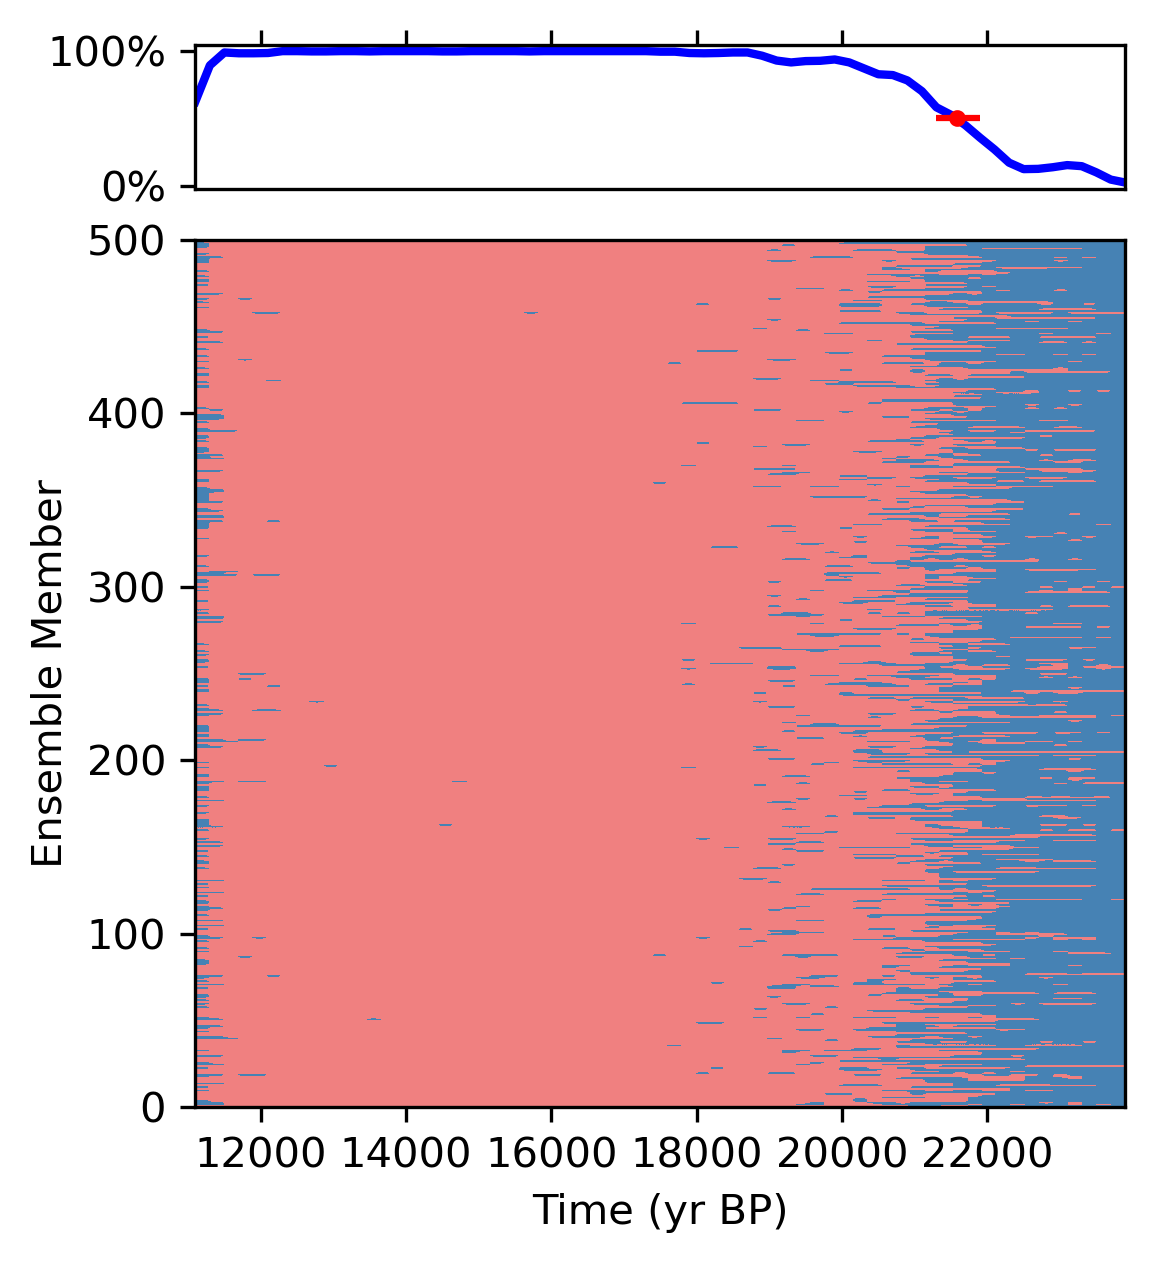

In [7]:
weighted_avg_curves_k = [curves[0] for curves in all_weighted_avg_curves]


# loop through each data in weighted_avg_curves_k and calculate the mean between index 35 to 54 (correpsonding to 18100 to 21000 BP)
for j in range(len(weighted_avg_curves_k)):
    data=weighted_avg_curves_k[j]
    data_18100_21000=np.mean(data[35:55])
    data=data-data_18100_21000
    weighted_avg_curves_k[j]=data


sigmas = list(range(1, 20, 1))  # Sigma values for Gaussian smoothing
significance_results = analyze_significance(weighted_avg_curves_k, sigmas)
plot_significance_map_with_curve(significance_results, (time[0], time[-1]), len(weighted_avg_curves_k), figsize=(4, 4.6),if_colorbar=False)

Mean of time_50_mc: 17220.0
5th percentile of time_50_mc: 17100.0
95th percentile of time_50_mc: 17300.0


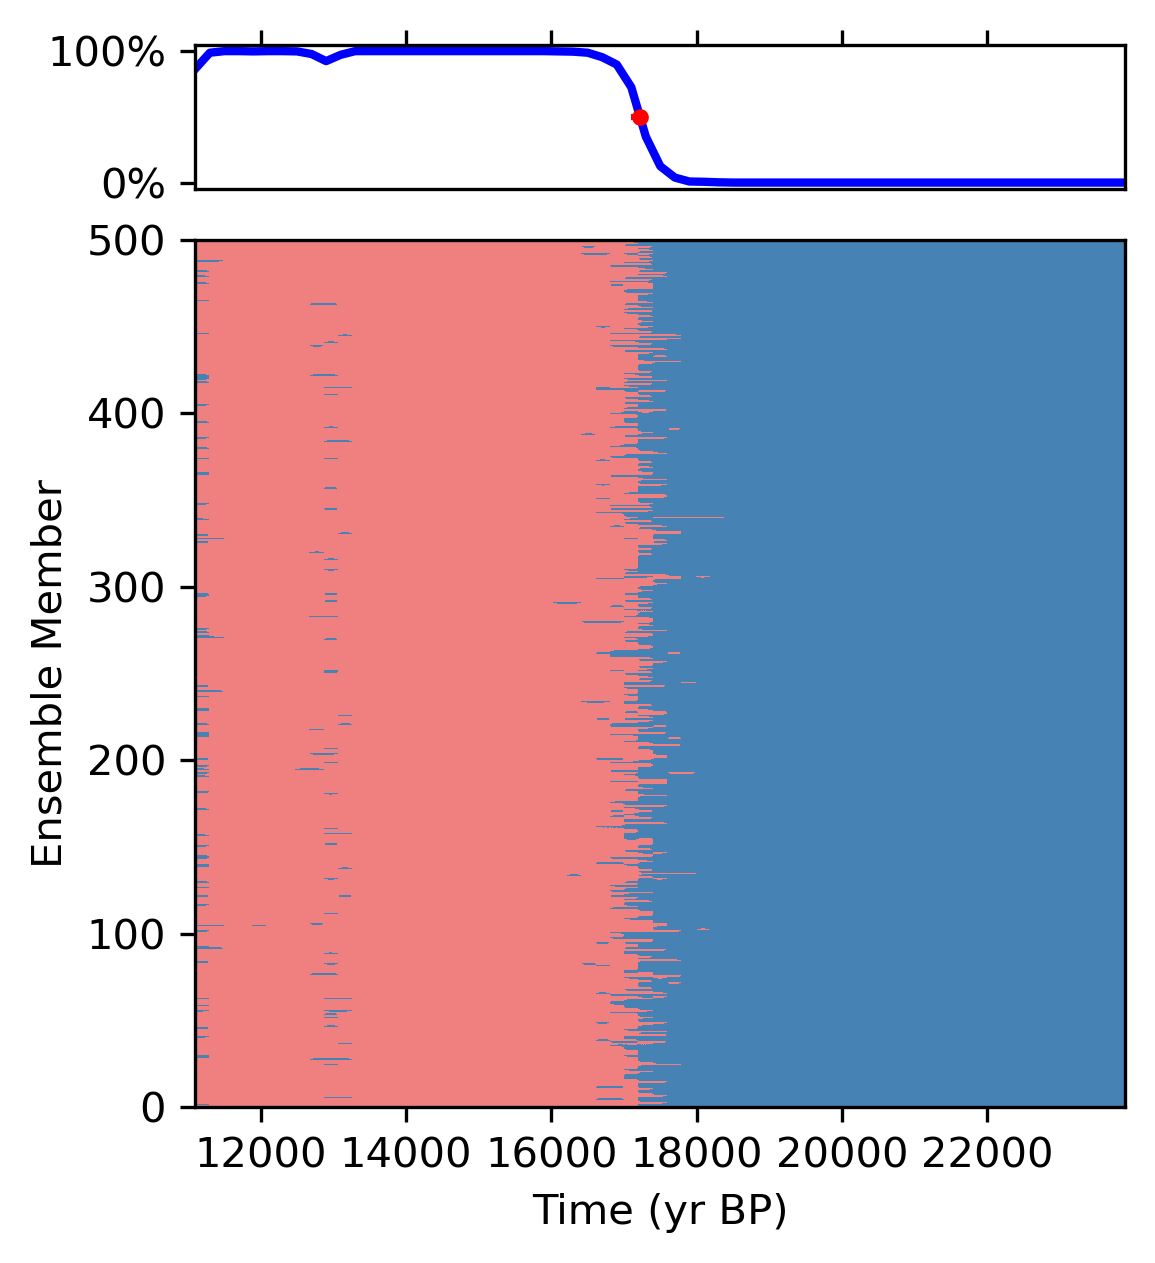

In [8]:
weighted_avg_curves_k = [curves[1] for curves in all_weighted_avg_curves]


# loop through each data in weighted_avg_curves_k and calculate the mean between index 35 to 54 (correpsonding to 18100 to 21000 BP)
for j in range(len(weighted_avg_curves_k)):
    data=weighted_avg_curves_k[j]
    data_18100_21000=np.mean(data[35:55])
    data=data-data_18100_21000
    weighted_avg_curves_k[j]=data


sigmas = list(range(1, 20, 1))  # Sigma values for Gaussian smoothing
significance_results = analyze_significance(weighted_avg_curves_k, sigmas)
plot_significance_map_with_curve(significance_results, (time[0], time[-1]), len(weighted_avg_curves_k), figsize=(4, 4.6),if_colorbar=False)

Mean of time_50_mc: 20120.0
5th percentile of time_50_mc: 20090.0
95th percentile of time_50_mc: 20300.0


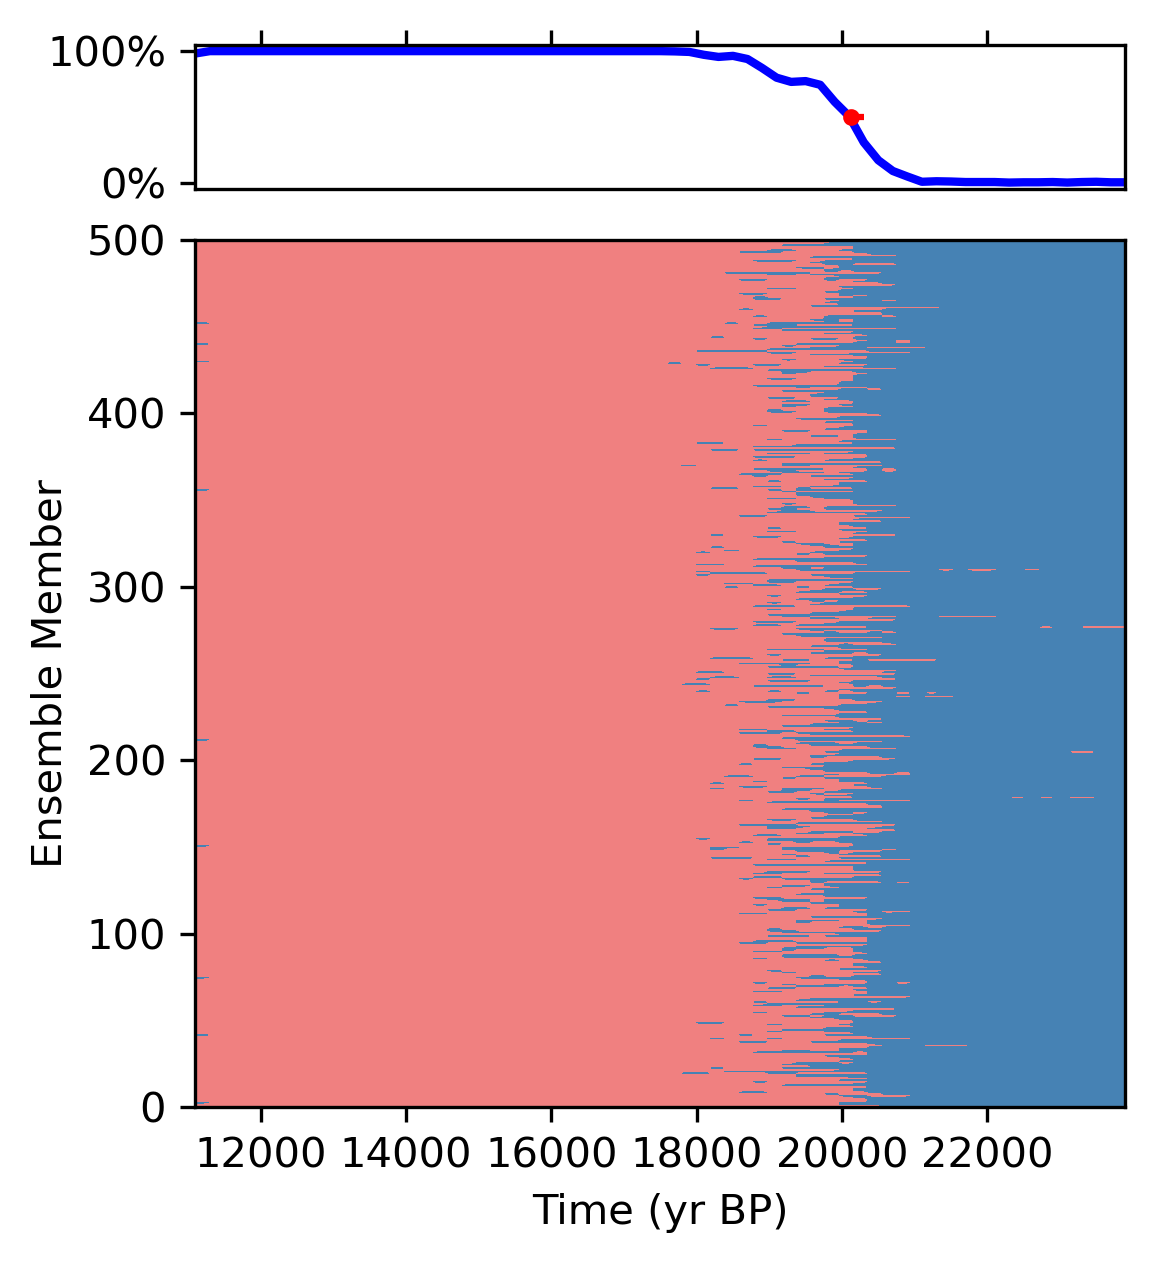

In [9]:
weighted_avg_curves_k = [curves[2] for curves in all_weighted_avg_curves]


# loop through each data in weighted_avg_curves_k and calculate the mean between index 35 to 54 (correpsonding to 18100 to 21000 BP)
for j in range(len(weighted_avg_curves_k)):
    data=weighted_avg_curves_k[j]
    data_18100_21000=np.mean(data[35:55])
    data=data-data_18100_21000
    weighted_avg_curves_k[j]=data


sigmas = list(range(1, 20, 1))  # Sigma values for Gaussian smoothing
significance_results = analyze_significance(weighted_avg_curves_k, sigmas)
plot_significance_map_with_curve(significance_results, (time[0], time[-1]), len(weighted_avg_curves_k), figsize=(4, 4.6),if_colorbar=False)

Mean of time_50_mc: 18040.0
5th percentile of time_50_mc: 17900.0
95th percentile of time_50_mc: 18110.0


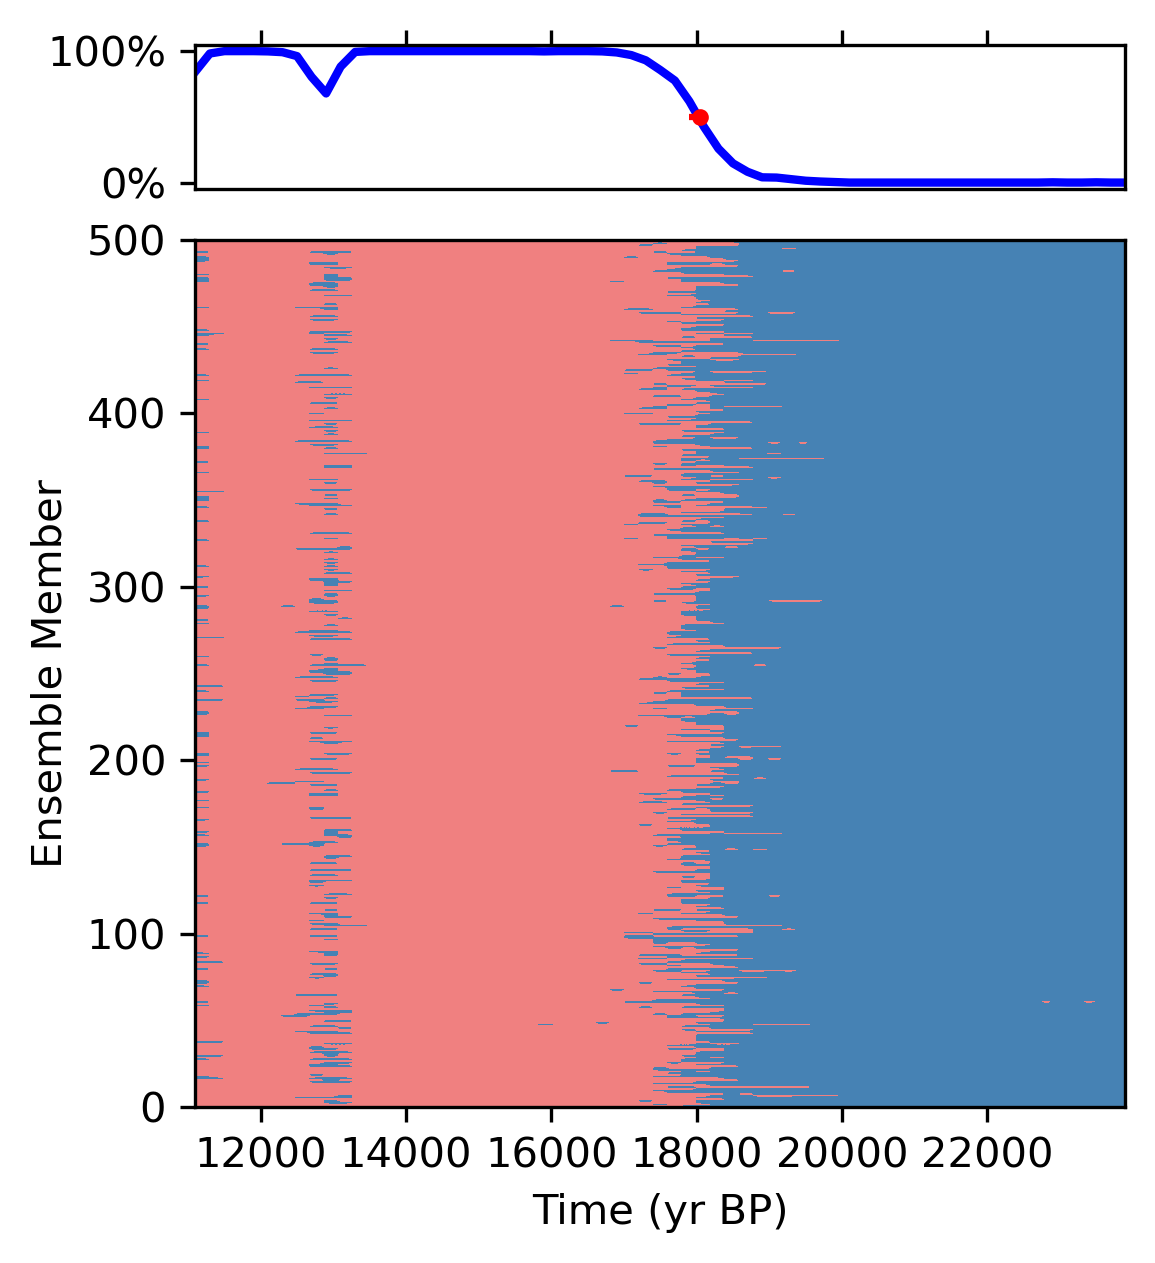

In [62]:
weighted_avg_curves_k = [curves[3] for curves in all_weighted_avg_curves]


# loop through each data in weighted_avg_curves_k and calculate the mean between index 35 to 54 (correpsonding to 18100 to 21000 BP)
for j in range(len(weighted_avg_curves_k)):
    data=weighted_avg_curves_k[j]
    data_18100_21000=np.mean(data[35:55])
    data=data-data_18100_21000
    weighted_avg_curves_k[j]=data


sigmas = list(range(1, 20, 1))  # Sigma values for Gaussian smoothing
significance_results = analyze_significance(weighted_avg_curves_k, sigmas)
plot_significance_map_with_curve(significance_results, (time[0], time[-1]), len(weighted_avg_curves_k), figsize=(4, 4.6),if_colorbar=False)

Mean of time_50_mc: 18010.0
5th percentile of time_50_mc: 17900.0
95th percentile of time_50_mc: 18100.0


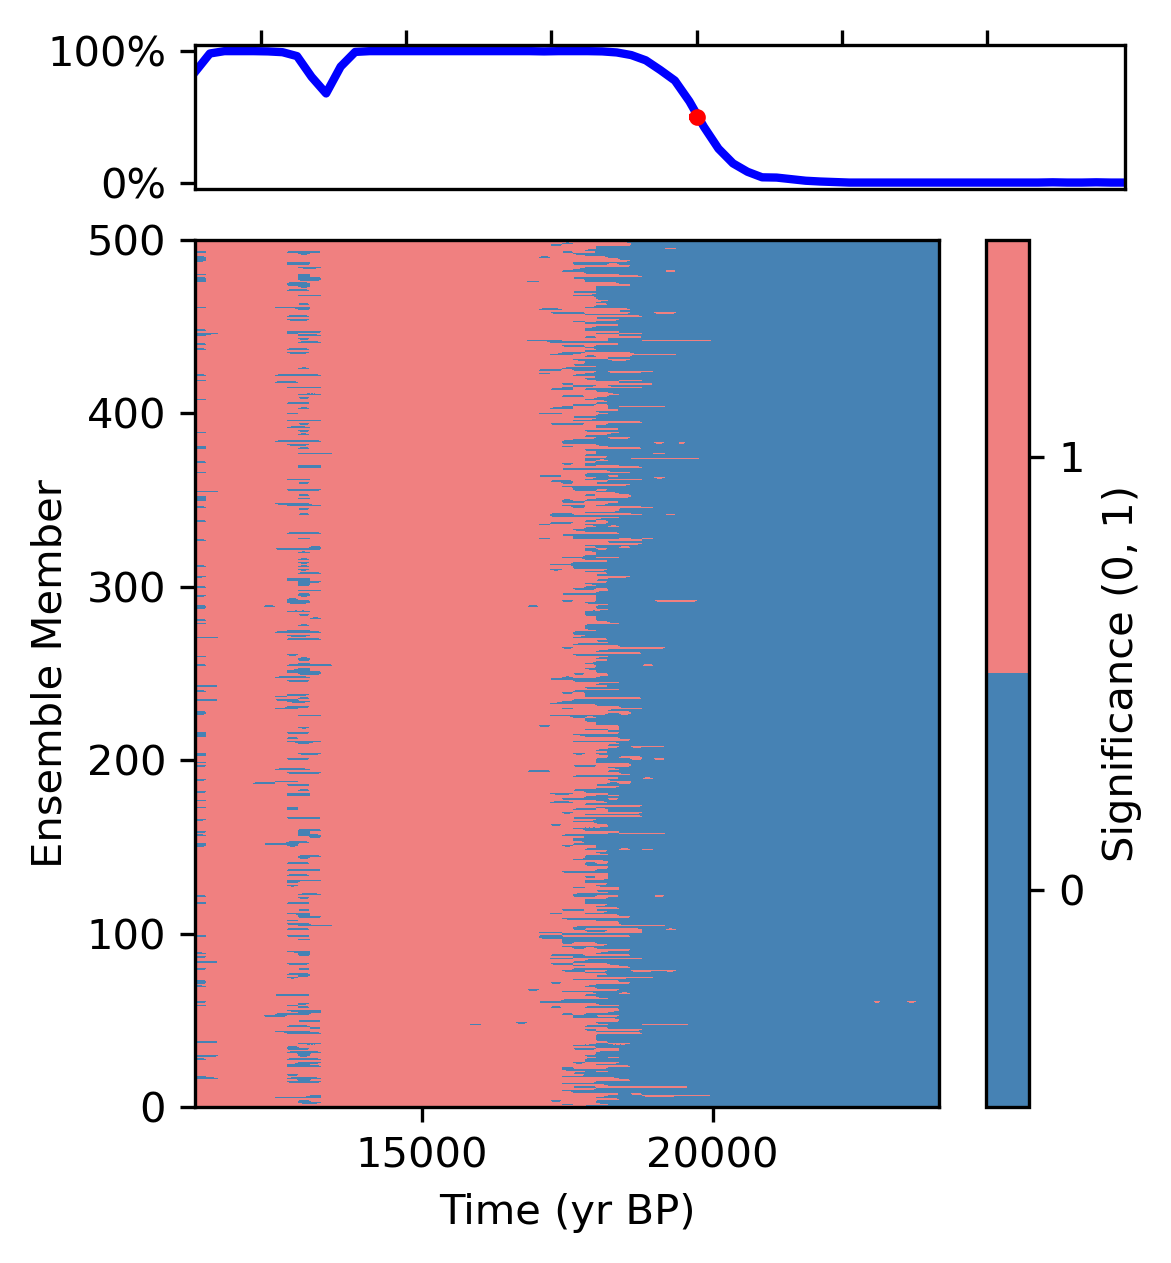

In [63]:
plot_significance_map_with_curve(significance_results, (time[0], time[-1]), len(weighted_avg_curves_k), figsize=(4, 4.6),if_colorbar=True)

In [27]:
weighted_avg_curves_k[0].shape

(65,)

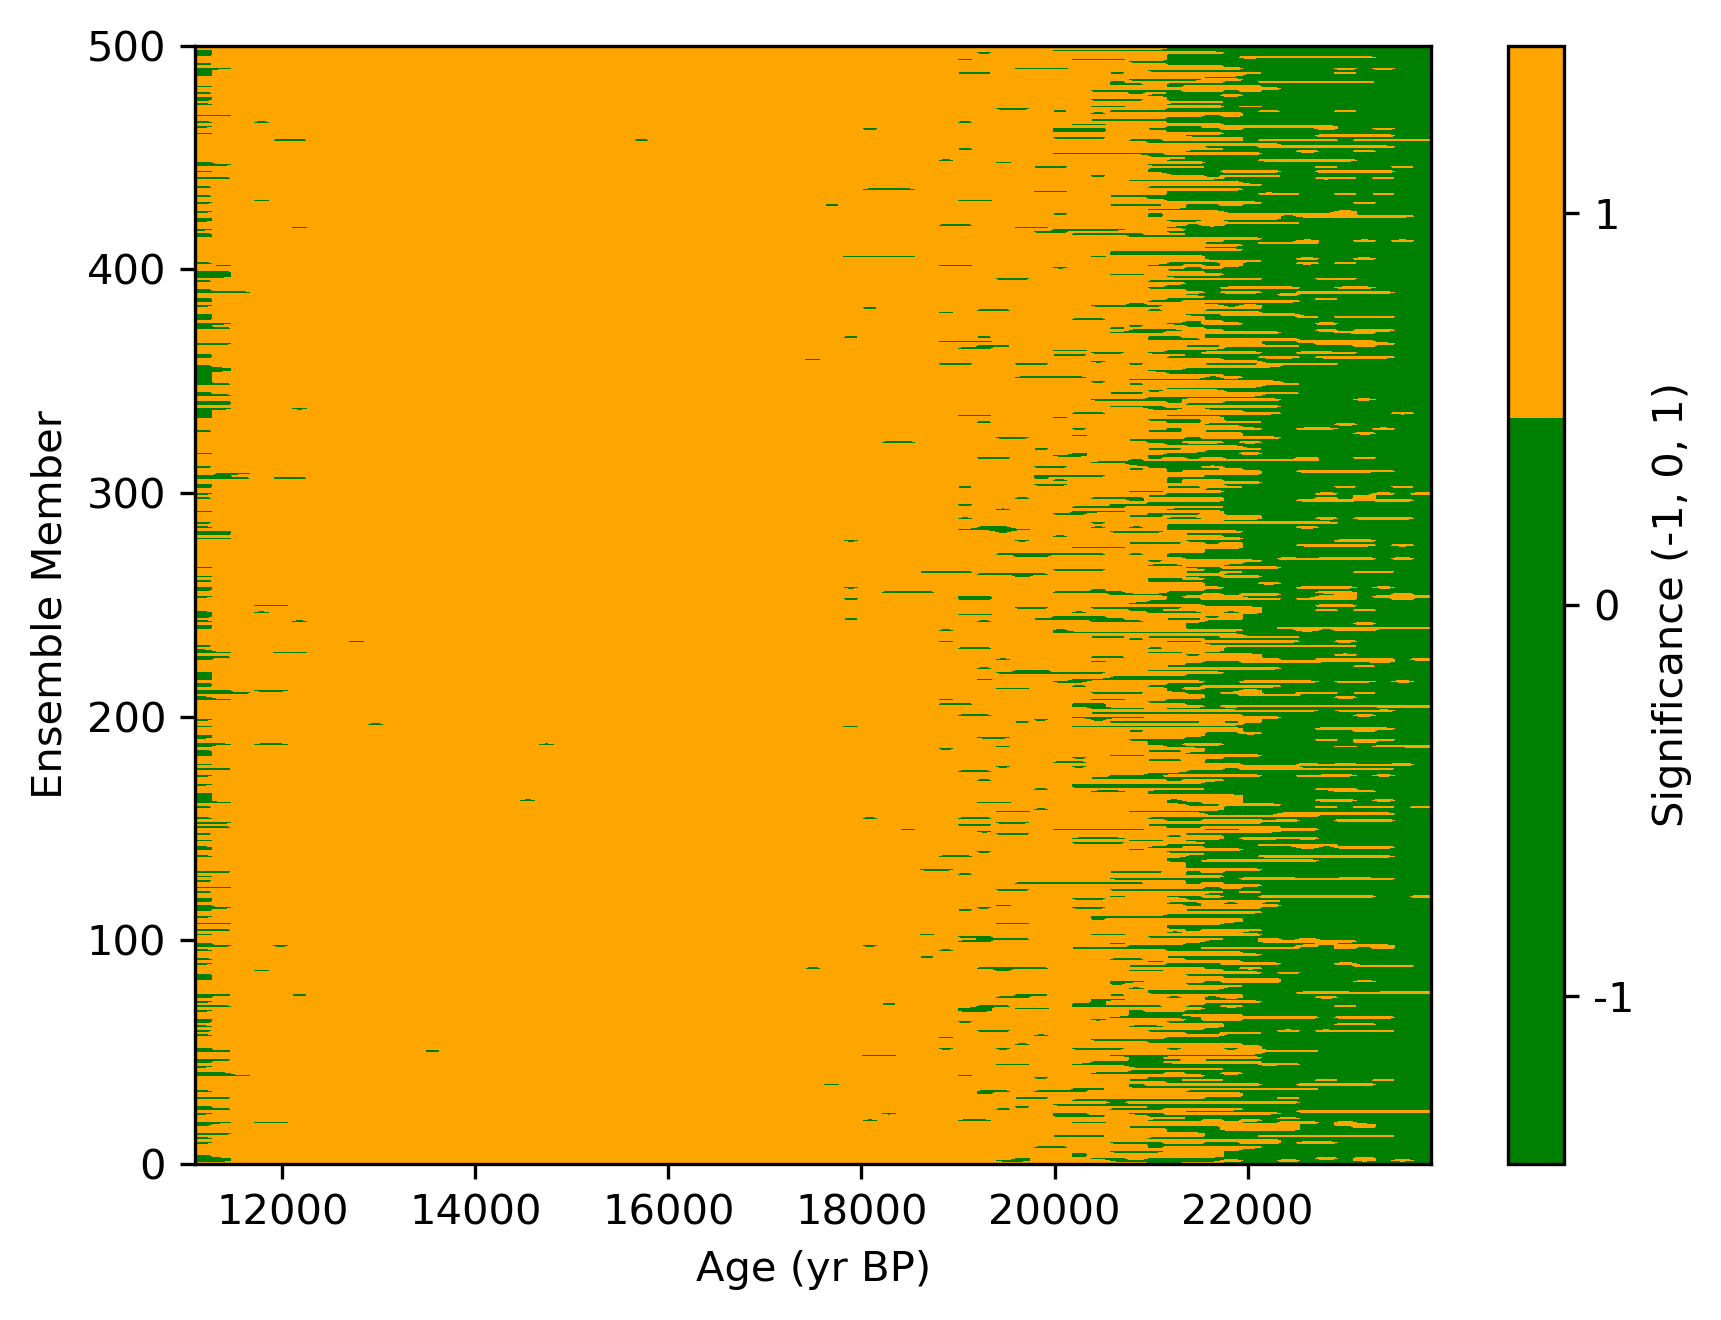

In [9]:
weighted_avg_curves_k = [curves[0] for curves in all_weighted_avg_curves]


# loop through each data in weighted_avg_curves_k and calculate the mean between index 35 to 54 (correpsonding to 18100 to 21000 BP)
for j in range(len(weighted_avg_curves_k)):
    data=weighted_avg_curves_k[j]
    data_18100_21000=np.mean(data[35:55])
    data=data-data_18100_21000
    weighted_avg_curves_k[j]=data


sigmas = list(range(1, 20, 1))  # Sigma values for Gaussian smoothing
significance_results = analyze_significance(weighted_avg_curves_k, sigmas)
plot_significance_map(significance_results, (time[0], time[-1]), len(weighted_avg_curves_k))

In [83]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_1samp

def smooth_gaussian(data, sigma):
    """
    Smooth a time series using a Gaussian kernel.
    
    Parameters:
        data (array-like): The time series data to be smoothed.
        sigma (float): The standard deviation for Gaussian kernel, determines the amount of smoothing.
        
    Returns:
        ndarray: The smoothed time series data.
    """
    smoothed_data = gaussian_filter1d(data, sigma=sigma)
    return smoothed_data

def analyze_significance(time_series_data, sigmas):
    """
    Analyze the significance of derivatives across multiple time series data with Gaussian smoothing.
    
    Parameters:
        time_series_data (list of ndarray): A list containing multiple time series data.
        sigmas (list of int): A list of sigma values for Gaussian smoothing.
    
    Returns:
        list of ndarray: A list of arrays where each array contains the significance coding (-1, 0, 1) for each time point.
    """
    all_significance_arrays = []
    
    for time_series in time_series_data:
        derivatives_matrix = []
        
        for sigma in sigmas:
            smoothed_data = smooth_gaussian(time_series, sigma)
            derivative = np.gradient(smoothed_data) * -1
            derivatives_matrix.append(derivative)
        
        derivatives_matrix = np.array(derivatives_matrix).T
        significance_array = np.zeros_like(time_series)
        
        for i in range(len(derivatives_matrix)):
            _, p_value = ttest_1samp(derivatives_matrix[i], 0)
            if p_value < 0.05:
                mean_derivative = np.mean(derivatives_matrix[i])
                if mean_derivative < 0:
                    significance_array[i] = -1
                elif mean_derivative > 0:
                    significance_array[i] = 1
        
        all_significance_arrays.append(significance_array)
    
    return all_significance_arrays



import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_significance_map(significance_arrays, time_range, ensemble_count, figsize=(6, 4.5), dpi=300):
    """
    Plots a 2D color map of significance results for multiple time series.
    
    Parameters:
        significance_arrays (list of ndarray): A list of arrays containing significance values for each time series.
        time_range (tuple): A tuple (min_time, max_time) defining the extent of the time dimension.
        ensemble_count (int): The number of time series (ensemble members).
        figsize (tuple): The dimensions of the figure to be plotted.
        dpi (int): The resolution of the figure in dots per inch.
    """
    # Define custom colormap
    colors = ['cyan', 'green', 'orange']  # Feel free to adjust colors
    cmap = ListedColormap(colors)
    
    plt.figure(figsize=figsize, dpi=dpi)
    img = plt.imshow(significance_arrays, aspect='auto', cmap=cmap, extent=[time_range[0], time_range[1], 0, ensemble_count], vmin=-1, vmax=1)
    
    # Set colorbar with ticks and labels adjusted for middle alignment
    cbar = plt.colorbar(img, ticks=[-0.7, 0, 0.7], label='Significance (-1, 0, 1)')
    cbar.set_ticklabels(['-1', '0', '1'])
    
    plt.xlabel('Age (yr BP)')
    plt.ylabel('Ensemble Member')
    plt.tight_layout()
    plt.show()



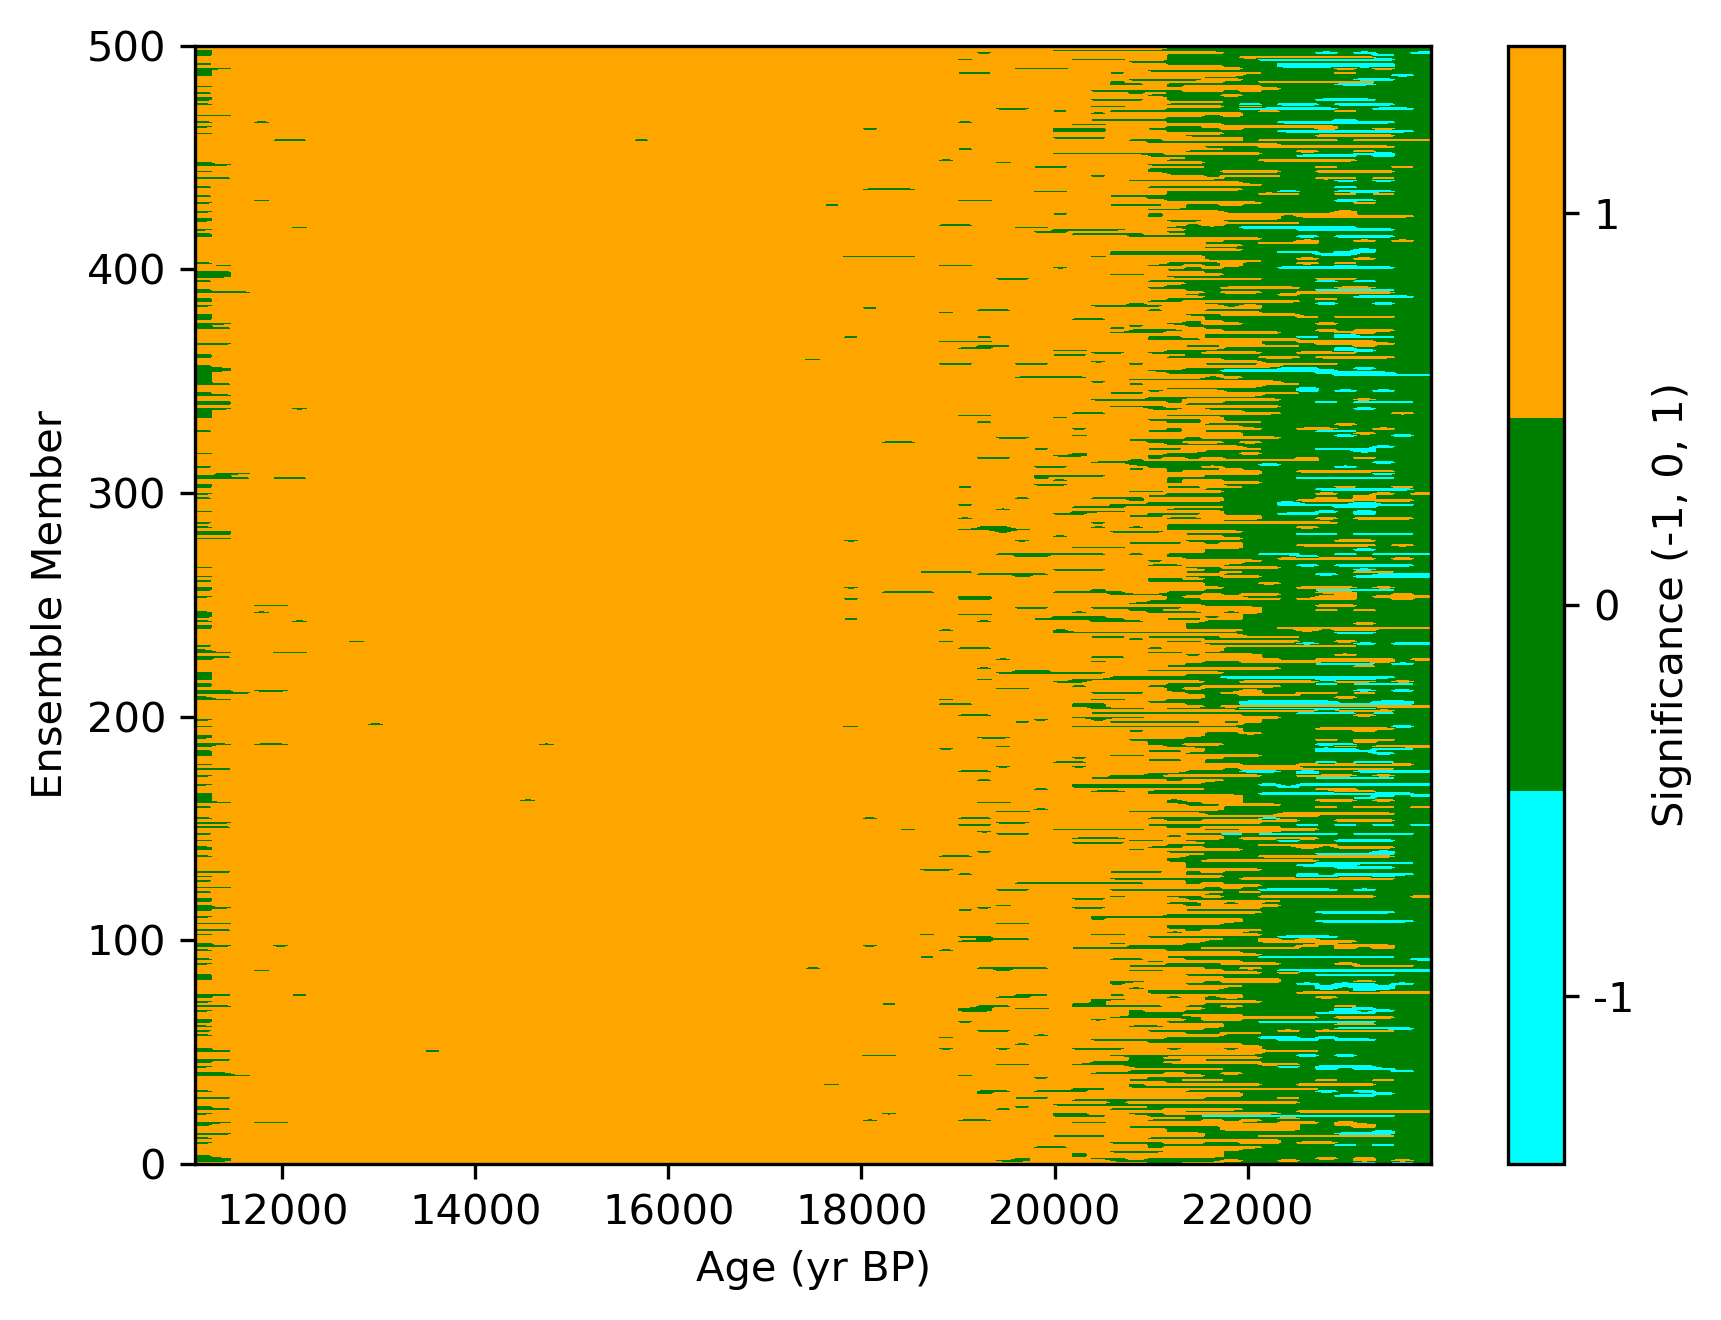

In [84]:
weighted_avg_curves_k = [curves[0] for curves in all_weighted_avg_curves]


# loop through each data in weighted_avg_curves_k and calculate the mean between index 35 to 54 (correpsonding to 18100 to 21000 BP)
for j in range(len(weighted_avg_curves_k)):
    data=weighted_avg_curves_k[j]
    data_18100_21000=np.mean(data[35:55])
    data=data-data_18100_21000
    weighted_avg_curves_k[j]=data


sigmas = list(range(1, 20, 1))  # Sigma values for Gaussian smoothing
significance_results = analyze_significance(weighted_avg_curves_k, sigmas)
plot_significance_map(significance_results, (time[0], time[-1]), len(weighted_avg_curves_k))

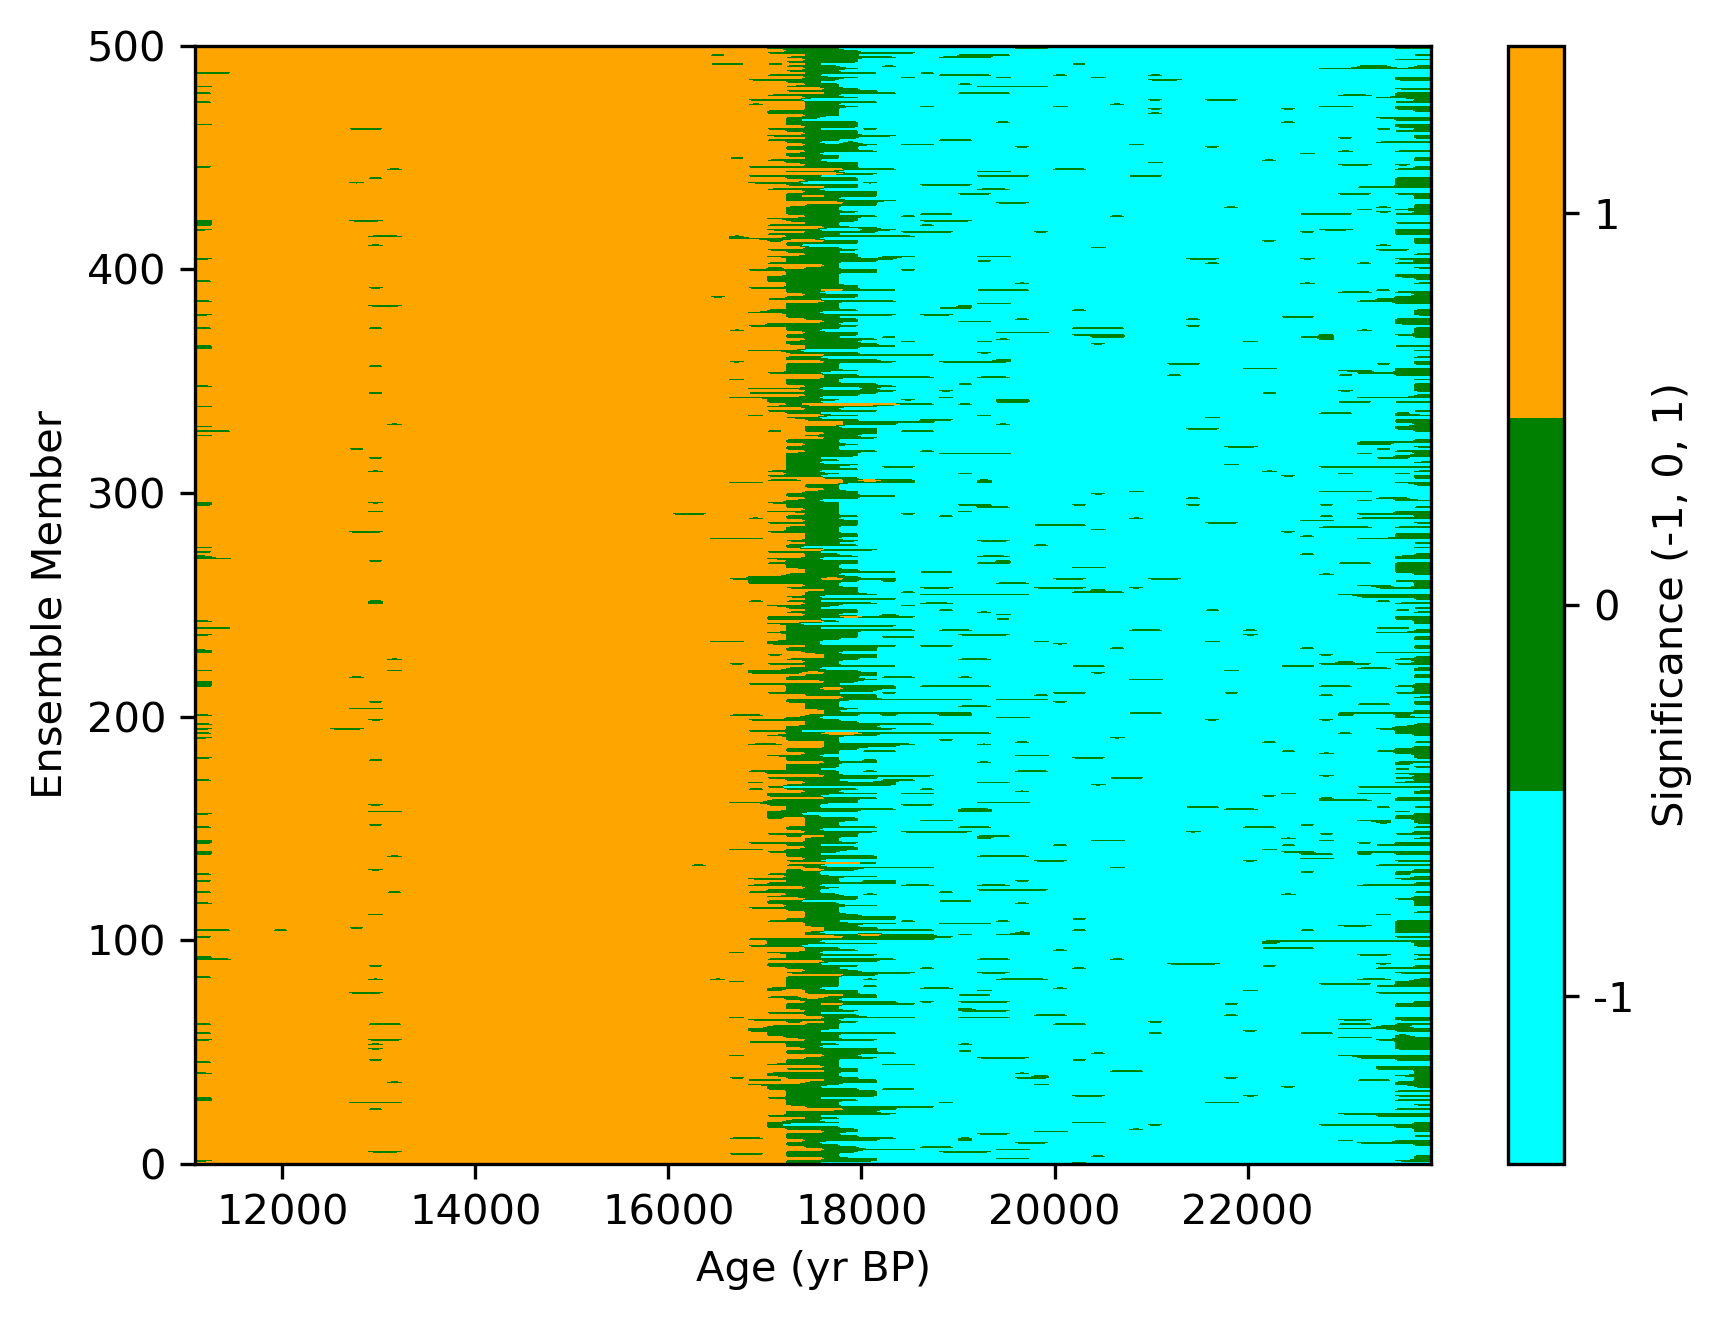

In [87]:
weighted_avg_curves_k = [curves[1] for curves in all_weighted_avg_curves]


# loop through each data in weighted_avg_curves_k and calculate the mean between index 35 to 54 (correpsonding to 18100 to 21000 BP)
for j in range(len(weighted_avg_curves_k)):
    data=weighted_avg_curves_k[j]
    data_18100_21000=np.mean(data[35:55])
    data=data-data_18100_21000
    weighted_avg_curves_k[j]=data


sigmas = list(range(1, 20, 1))  # Sigma values for Gaussian smoothing
significance_results = analyze_significance(weighted_avg_curves_k, sigmas)
plot_significance_map(significance_results, (time[0], time[-1]), len(weighted_avg_curves_k))

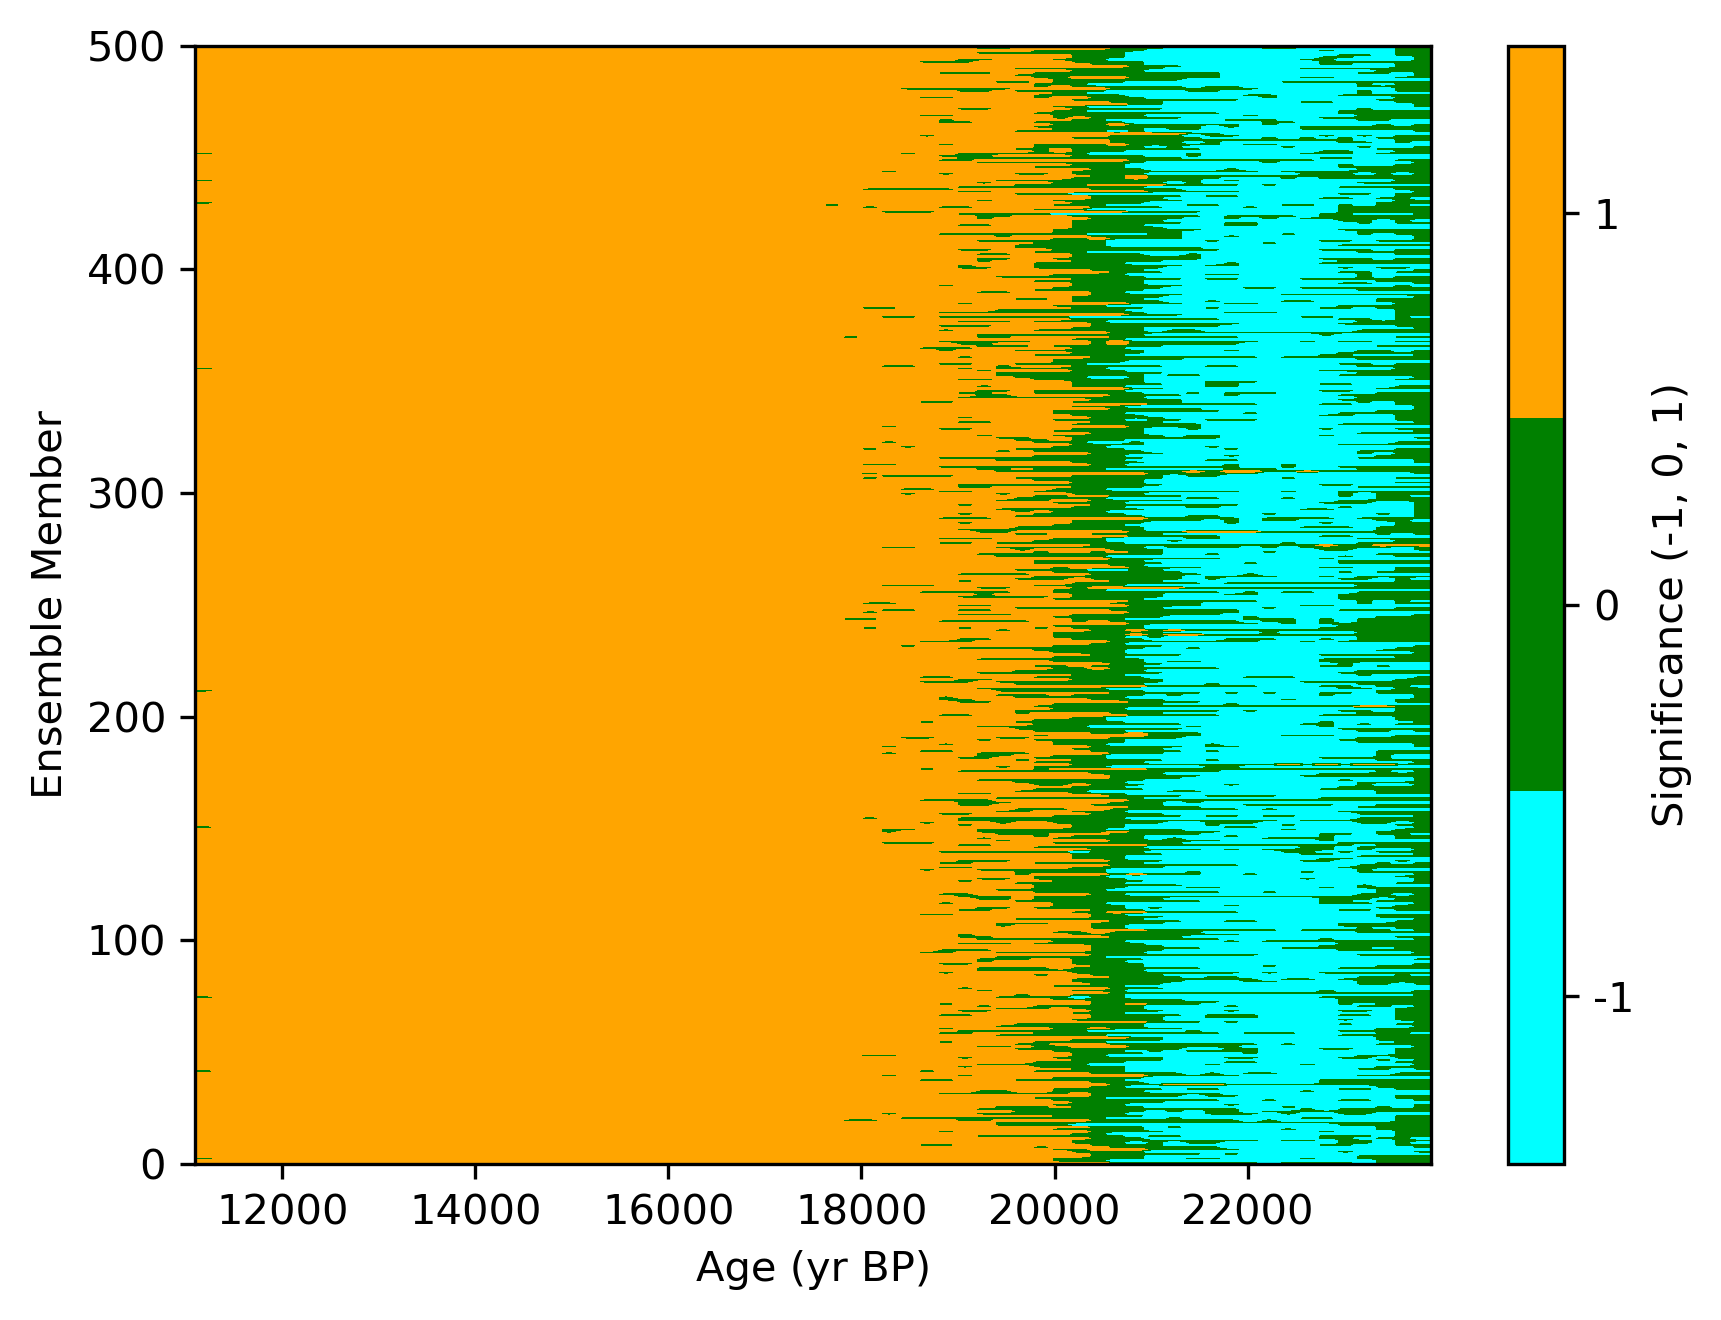

In [90]:
weighted_avg_curves_k = [curves[2] for curves in all_weighted_avg_curves]


# loop through each data in weighted_avg_curves_k and calculate the mean between index 35 to 54 (correpsonding to 18100 to 21000 BP)
for j in range(len(weighted_avg_curves_k)):
    data=weighted_avg_curves_k[j]
    data_18100_21000=np.mean(data[35:55])
    data=data-data_18100_21000
    weighted_avg_curves_k[j]=data


sigmas = list(range(1, 20, 1))  # Sigma values for Gaussian smoothing
significance_results = analyze_significance(weighted_avg_curves_k, sigmas)
plot_significance_map(significance_results, (time[0], time[-1]), len(weighted_avg_curves_k))

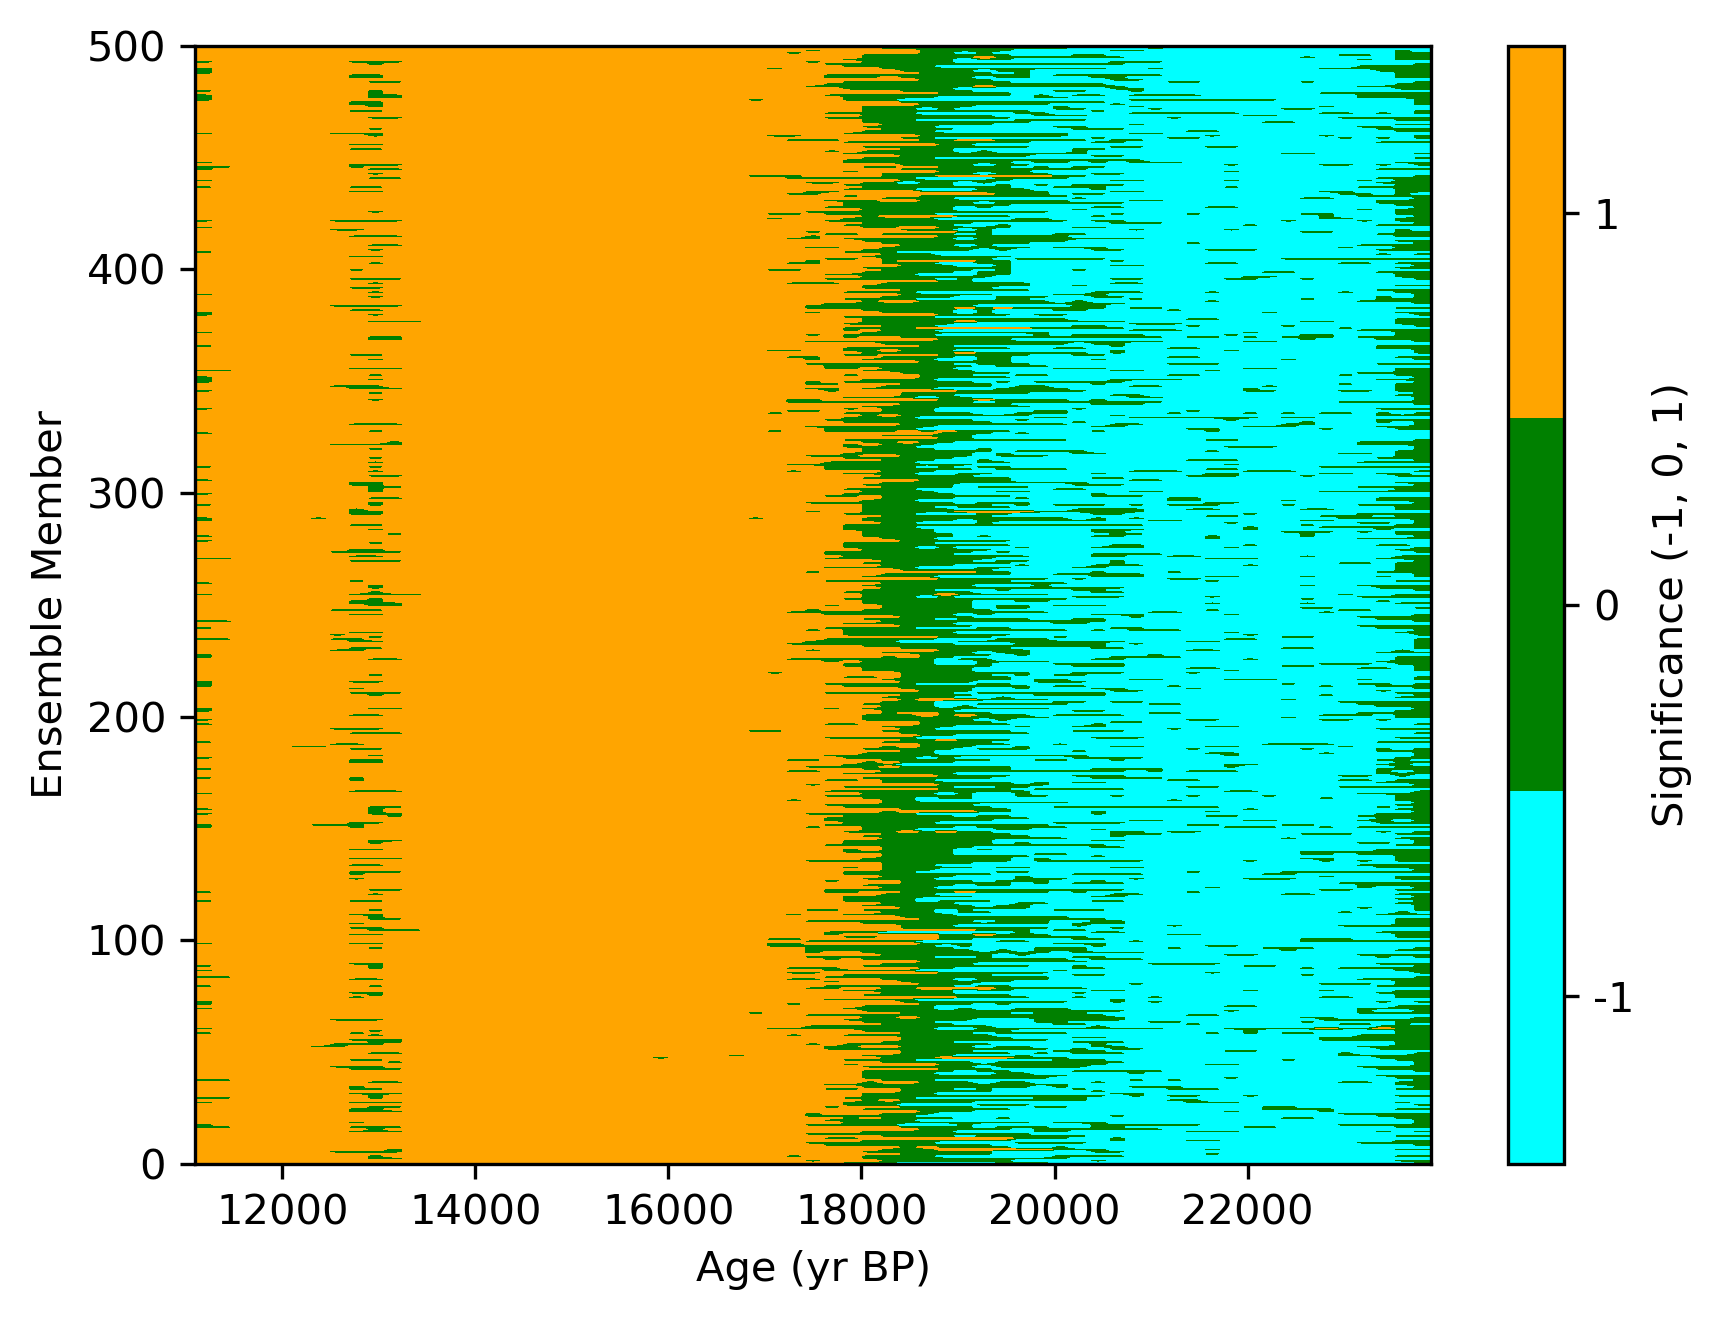

In [89]:
weighted_avg_curves_k = [curves[3] for curves in all_weighted_avg_curves]


# loop through each data in weighted_avg_curves_k and calculate the mean between index 35 to 54 (correpsonding to 18100 to 21000 BP)
for j in range(len(weighted_avg_curves_k)):
    data=weighted_avg_curves_k[j]
    data_18100_21000=np.mean(data[35:55])
    data=data-data_18100_21000
    weighted_avg_curves_k[j]=data


sigmas = list(range(1, 20, 1))  # Sigma values for Gaussian smoothing
significance_results = analyze_significance(weighted_avg_curves_k, sigmas)
plot_significance_map(significance_results, (time[0], time[-1]), len(weighted_avg_curves_k))

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_1samp

    

def smooth_gaussian(data, sigma):
    """
    Smooth a time series using a Gaussian kernel.
    """
    smoothed_data = gaussian_filter1d(data, sigma=sigma)
    return smoothed_data


sigmas = list(range(1, 20, 1))  # Sigma values for Gaussian smoothing

# Prepare to store all significance arrays
all_significance_arrays = []

for time_series in weighted_avg_curves_k:
    # print(len(time_series))
    derivatives_matrix = []
    original_derivative = np.gradient(time_series) * -1
    # derivatives_matrix.append(original_derivative)

    for sigma in sigmas:
        smoothed_data = smooth_gaussian(time_series, sigma)
        derivative = np.gradient(smoothed_data) * -1
        derivatives_matrix.append(derivative)

    derivatives_matrix = np.array(derivatives_matrix).T
    significance_array = np.zeros_like(time_series)

    for i in range(len(derivatives_matrix)):
        _, p_value = ttest_1samp(derivatives_matrix[i], 0)
        if p_value < 0.05:
            mean_derivative = np.mean(derivatives_matrix[i])
            if mean_derivative < 0:
                significance_array[i] = -1
            elif mean_derivative > 0:
                significance_array[i] = 1

    all_significance_arrays.append(significance_array)




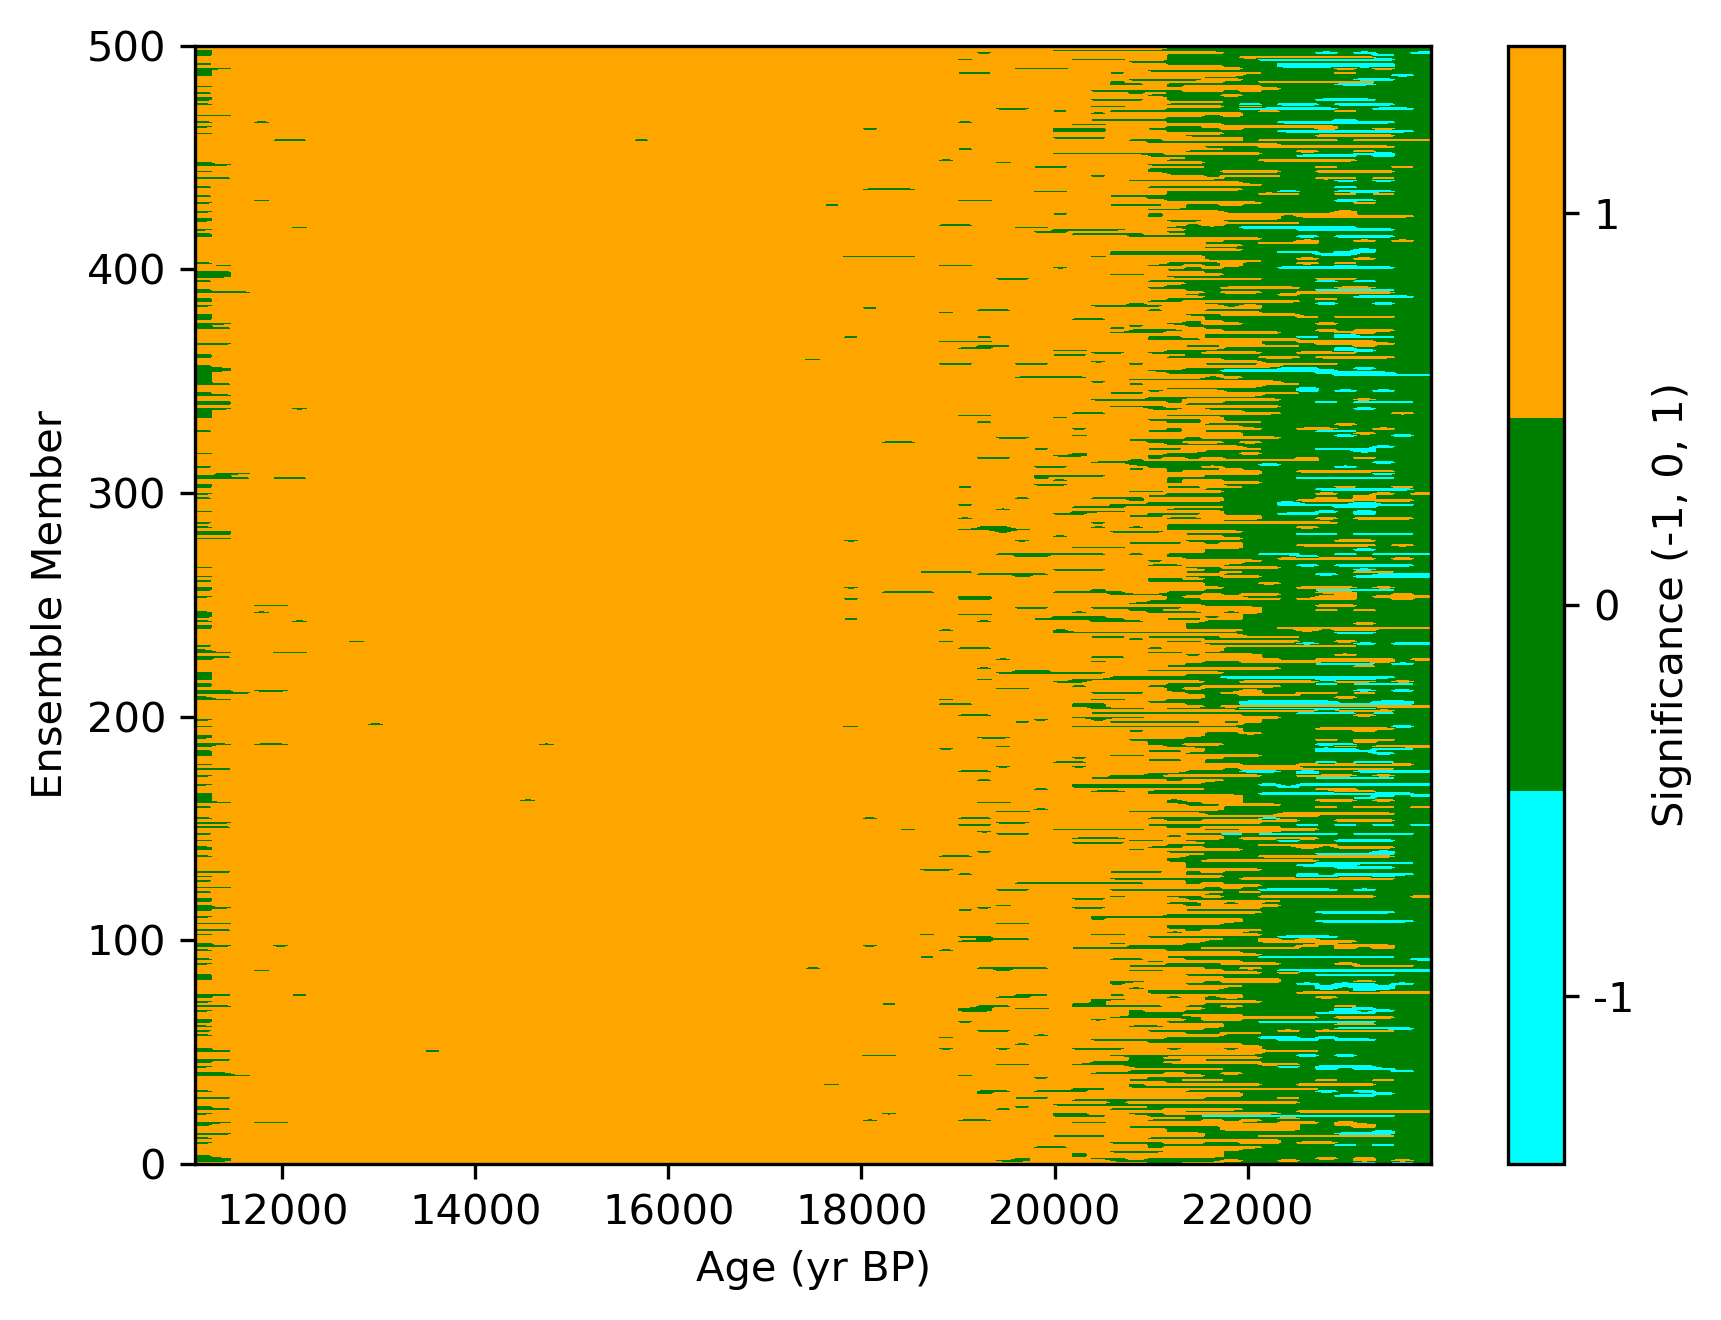

In [73]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# Define custom colormap
colors = ['cyan', 'green', 'orange'] 
cmap = ListedColormap(colors)

# Plotting the 2D color map of significance results
plt.figure(figsize=(6, 4.5),dpi=300)
plt.imshow(all_significance_arrays, aspect='auto', cmap=cmap, extent=[np.min(time), np.max(time), 0, len(weighted_avg_curves_k)], vmin=-1, vmax=1)
cbar=plt.colorbar(ticks=[-0.7, 0, 0.7], label='Significance (-1, 0, 1)')
# set the tick labels for the color bar
cbar.set_ticklabels(['-1', '0', '1'])
# plt.title('2D Color Map of Significance Arrays')
plt.xlabel('Age (yr BP)')
plt.ylabel('Ensemble Member')
plt.tight_layout()
plt.show()

In [33]:
len(derivative)

65

In [36]:
len(derivatives_matrix[0])

20

In [29]:
len(derivatives_matrix[0])

20

In [28]:
len(derivatives_matrix[1])

20

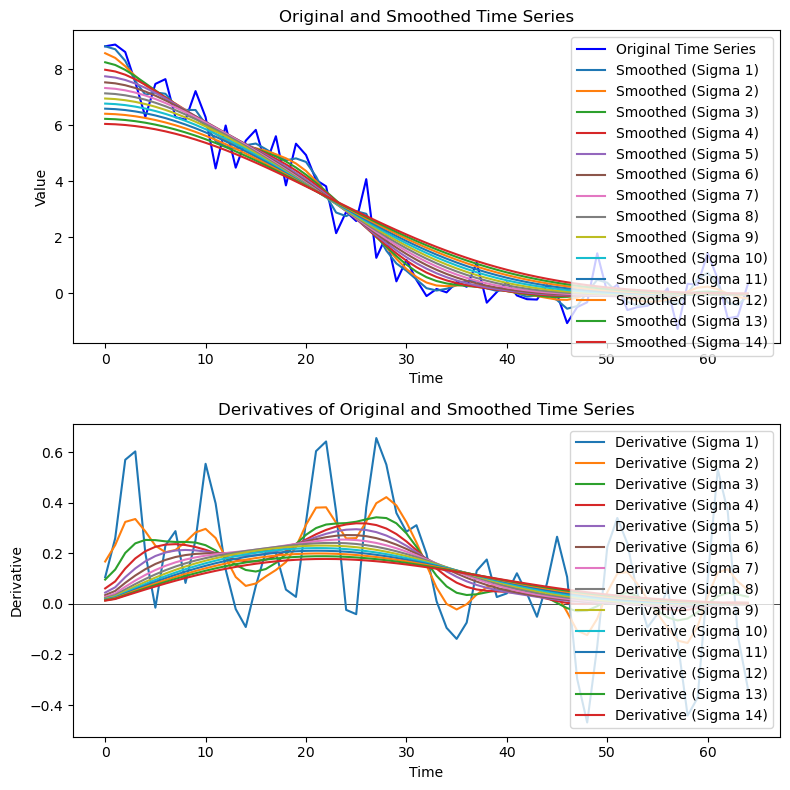

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def smooth_gaussian(data, sigma):
    """
    Smooth a time series using a Gaussian kernel.
    
    Parameters:
        data (array-like): The time series data to be smoothed.
        sigma (float): The standard deviation for Gaussian kernel, determines the amount of smoothing.
        
    Returns:
        smoothed_data (ndarray): The smoothed time series data.
    """
    smoothed_data = gaussian_filter1d(data, sigma=sigma)
    return smoothed_data

time_series = weighted_avg_curves_k[0]

# Define sigma values for Gaussian smoothing
sigmas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Plot original time series and derivatives
plt.figure(figsize=(8, 8))

# Plot original time series
plt.subplot(2, 1, 1)
plt.plot(time_series, label='Original Time Series', color='blue')

# Plot smoothed time series for each sigma
for sigma in sigmas:
    smoothed_data = smooth_gaussian(time_series, sigma)
    plt.plot(smoothed_data, label=f'Smoothed (Sigma {sigma})')

plt.title('Original and Smoothed Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Calculate and plot derivatives
plt.subplot(2, 1, 2)
plt.axhline(0, color='black', linewidth=0.5)  # Horizontal line at y=0
for sigma in sigmas:
    smoothed_data = smooth_gaussian(time_series, sigma)
    derivative = np.gradient(smoothed_data)*-1
    plt.plot(derivative, label=f'Derivative (Sigma {sigma})')

plt.title('Derivatives of Original and Smoothed Time Series')
plt.xlabel('Time')
plt.ylabel('Derivative')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_17816\2806958532.py:36: RankWarning: Polyfit may be poorly conditioned
  smoothed_data = smooth_polynomial(time_series, order)
C:\Users\User\AppData\Local\Temp\ipykernel_17816\2806958532.py:36: RankWarning: Polyfit may be poorly conditioned
  smoothed_data = smooth_polynomial(time_series, order)
C:\Users\User\AppData\Local\Temp\ipykernel_17816\2806958532.py:49: RankWarning: Polyfit may be poorly conditioned
  smoothed_data = smooth_polynomial(time_series, order)
C:\Users\User\AppData\Local\Temp\ipykernel_17816\2806958532.py:49: RankWarning: Polyfit may be poorly conditioned
  smoothed_data = smooth_polynomial(time_series, order)


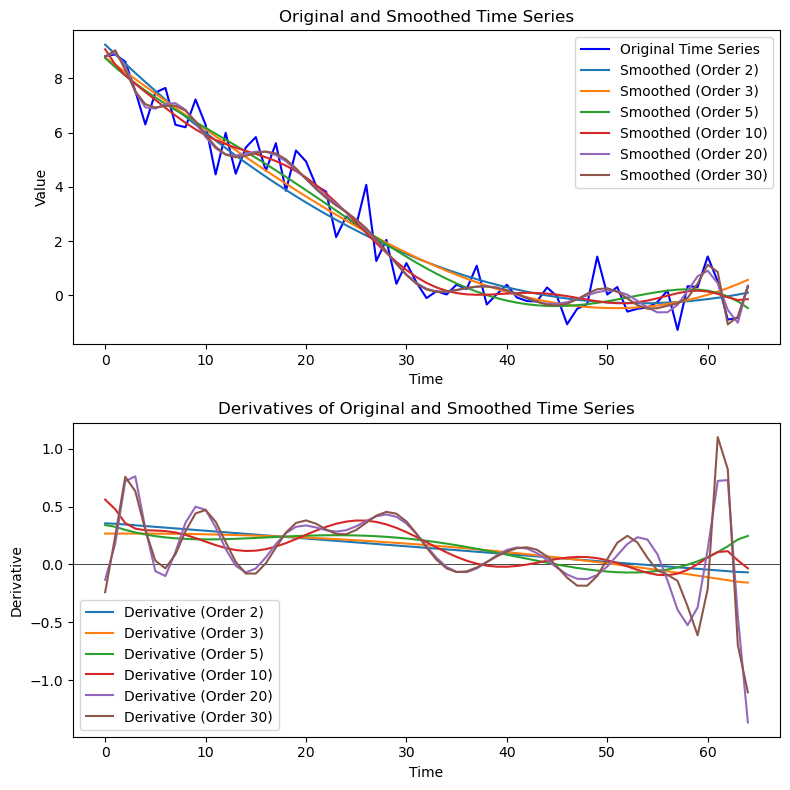

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_polynomial(data, order):
    """
    Smooth a time series using a polynomial of a given order.
    
    Parameters:
        data (array-like): The time series data to be smoothed.
        order (int): The order of the polynomial to use for smoothing.
        
    Returns:
        smoothed_data (ndarray): The smoothed time series data.
    """
    time = np.arange(len(data))
    coefficients = np.polyfit(time, data, order)
    polynomial = np.poly1d(coefficients)
    smoothed_data = polynomial(time)
    return smoothed_data


time_series = weighted_avg_curves_k[0]

# Define polynomial orders for smoothing
orders = [2, 3, 5, 10, 20, 30]

# Plot original time series and derivatives
plt.figure(figsize=(8, 8))

# Plot original time series
plt.subplot(2, 1, 1)
plt.plot(time_series, label='Original Time Series', color='blue')

# Plot smoothed time series for each order
for order in orders:
    smoothed_data = smooth_polynomial(time_series, order)
    plt.plot(smoothed_data, label=f'Smoothed (Order {order})')

plt.title('Original and Smoothed Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
# plt.grid(True)

# Calculate and plot derivatives
plt.subplot(2, 1, 2)
plt.axhline(0, color='black', linewidth=0.5)  # Horizontal line at y=0
for order in orders:
    smoothed_data = smooth_polynomial(time_series, order)
    derivative = np.gradient(smoothed_data)*-1
    plt.plot(derivative, label=f'Derivative (Order {order})')

plt.title('Derivatives of Original and Smoothed Time Series')
plt.xlabel('Time')
plt.ylabel('Derivative')
plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()


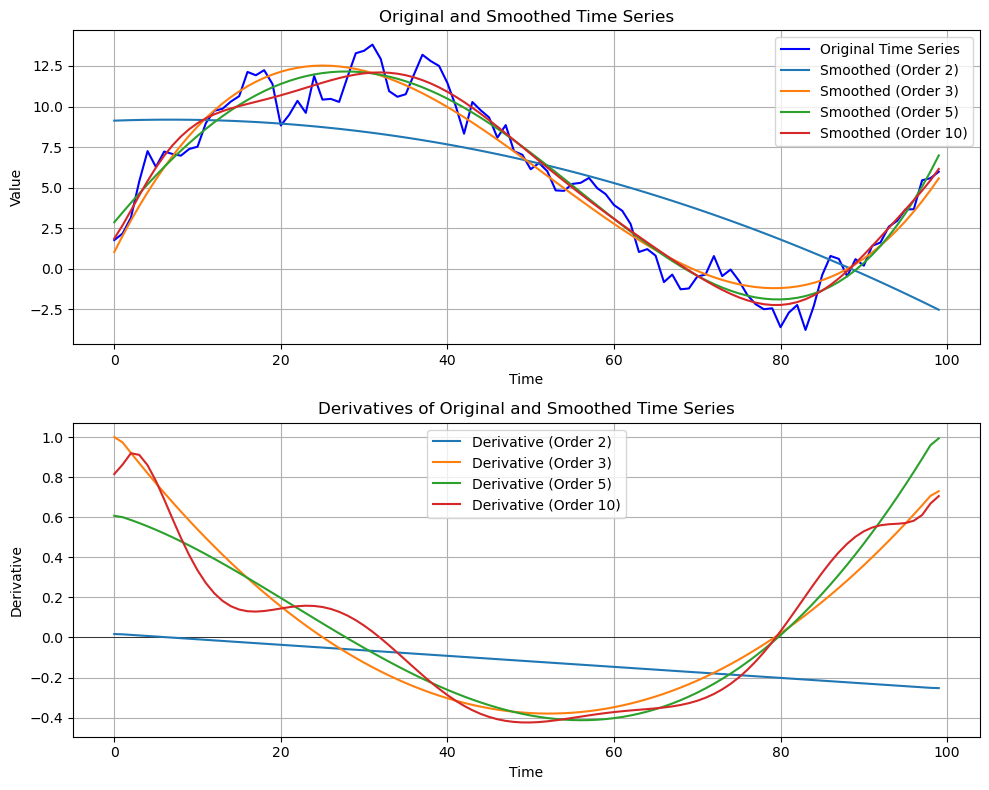

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_polynomial(data, order):
    """
    Smooth a time series using a polynomial of a given order.
    
    Parameters:
        data (array-like): The time series data to be smoothed.
        order (int): The order of the polynomial to use for smoothing.
        
    Returns:
        smoothed_data (ndarray): The smoothed time series data.
    """
    time = np.arange(len(data))
    coefficients = np.polyfit(time, data, order)
    polynomial = np.poly1d(coefficients)
    smoothed_data = polynomial(time)
    return smoothed_data

# Generate sample time series data
np.random.seed(0)
time_series = np.random.randn(100).cumsum()

# Define polynomial orders for smoothing
orders = [2, 3, 5, 10]

# Plot original time series and derivatives
plt.figure(figsize=(10, 8))

# Plot original time series
plt.subplot(2, 1, 1)
plt.plot(time_series, label='Original Time Series', color='blue')

# Plot smoothed time series for each order
for order in orders:
    smoothed_data = smooth_polynomial(time_series, order)
    plt.plot(smoothed_data, label=f'Smoothed (Order {order})')

plt.title('Original and Smoothed Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Calculate and plot derivatives
plt.subplot(2, 1, 2)
plt.axhline(0, color='black', linewidth=0.5)  # Horizontal line at y=0
for order in orders:
    smoothed_data = smooth_polynomial(time_series, order)
    derivative = np.gradient(smoothed_data)
    plt.plot(derivative, label=f'Derivative (Order {order})')

plt.title('Derivatives of Original and Smoothed Time Series')
plt.xlabel('Time')
plt.ylabel('Derivative')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


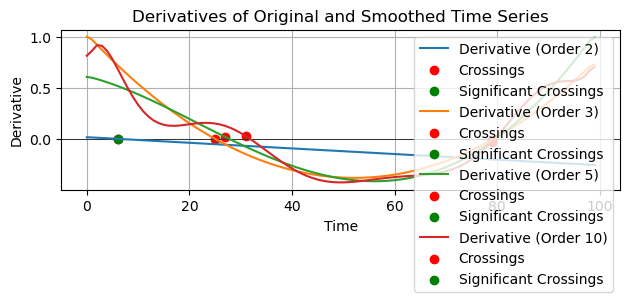

In [6]:
def find_crossings(derivative):
    """
    Find indices where the derivative changes sign (crosses zero).
    
    Parameters:
        derivative (ndarray): The derivative array.
        
    Returns:
        crossing_indices (list): List of indices where the derivative changes sign.
    """
    crossings = np.where(np.diff(np.sign(derivative)))[0]
    return crossings

# Calculate and plot derivatives
plt.subplot(2, 1, 2)
plt.axhline(0, color='black', linewidth=0.5)  # Horizontal line at y=0
for order in orders:
    smoothed_data = smooth_polynomial(time_series, order)
    derivative = np.gradient(smoothed_data)
    plt.plot(derivative, label=f'Derivative (Order {order})')

    # Find crossings
    crossings = find_crossings(derivative)
    plt.scatter(crossings, derivative[crossings], color='red', label='Crossings')

    # Calculate confidence intervals (example with bootstrap)
    num_samples = 1000
    bootstrap_samples = []
    for _ in range(num_samples):
        bootstrap_sample = np.random.choice(derivative, size=len(derivative), replace=True)
        bootstrap_samples.append(np.mean(bootstrap_sample))
    bootstrap_mean = np.mean(bootstrap_samples)
    bootstrap_std = np.std(bootstrap_samples)
    confidence_interval = (bootstrap_mean - 1.96 * bootstrap_std, bootstrap_mean + 1.96 * bootstrap_std)

    # Highlight significant crossings
    significant_crossings = [idx for idx in crossings if derivative[idx] < confidence_interval[0] or derivative[idx] > confidence_interval[1]]
    plt.scatter(significant_crossings, derivative[significant_crossings], color='green', label='Significant Crossings')

plt.title('Derivatives of Original and Smoothed Time Series')
plt.xlabel('Time')
plt.ylabel('Derivative')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


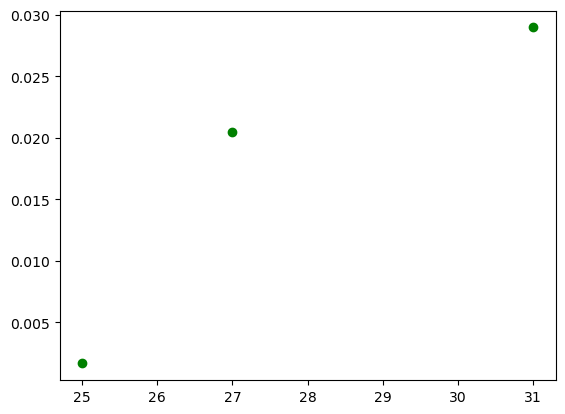

In [7]:
from statsmodels.regression.linear_model import OLS
from scipy.stats import chi2

def likelihood_ratio_test(data, idx):
    """
    Perform likelihood ratio test to assess significance of change point.
    
    Parameters:
        data (ndarray): The time series data.
        idx (int): Index of the potential change point.
        
    Returns:
        p_value (float): p-value of the likelihood ratio test.
    """
    n = len(data)
    n1 = idx
    n2 = n - idx
    
    # Fit model without change point
    model1 = OLS(data, np.ones((n, 1))).fit()
    RSS1 = model1.ssr
    
    # Fit model with change point
    model2 = OLS(data, np.concatenate([np.ones((n1, 1)), np.zeros((n2, 1))])).fit()
    RSS2 = model2.ssr
    
    # Calculate test statistic
    LR = (RSS1 - RSS2) / RSS2 * (n - 2)
    
    # Calculate p-value
    p_value = 1 - chi2.cdf(LR, 1)
    
    return p_value

# Perform change point analysis for each potential crossing point
for order in orders:
    smoothed_data = smooth_polynomial(time_series, order)
    derivative = np.gradient(smoothed_data)
    crossings = find_crossings(derivative)
    
    significant_crossings = []
    for crossing in crossings:
        p_value = likelihood_ratio_test(derivative, crossing)
        if p_value < 0.05:  # significance level of 0.05
            significant_crossings.append(crossing)
    
    # Plot significant crossings
    plt.scatter(significant_crossings, derivative[significant_crossings], color='green', label='Significant Crossings')


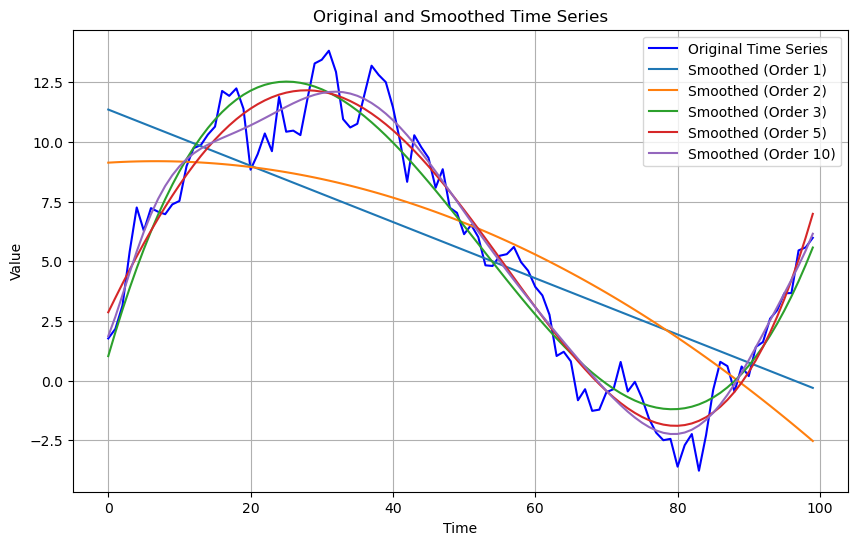

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_polynomial(data, order):
    """
    Smooth a time series using a polynomial of a given order.
    
    Parameters:
        data (array-like): The time series data to be smoothed.
        order (int): The order of the polynomial to use for smoothing.
        
    Returns:
        smoothed_data (ndarray): The smoothed time series data.
    """
    time = np.arange(len(data))
    coefficients = np.polyfit(time, data, order)
    polynomial = np.poly1d(coefficients)
    smoothed_data = polynomial(time)
    return smoothed_data

# Generate sample time series data
np.random.seed(0)
time_series = np.random.randn(100).cumsum()

# Define polynomial orders for smoothing
orders = [1,2, 3, 5, 10]

# Plot original time series
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Original Time Series', color='blue')

# Plot smoothed time series for each order
for order in orders:
    smoothed_data = smooth_polynomial(time_series, order)
    plt.plot(smoothed_data, label=f'Smoothed (Order {order})')

plt.title('Original and Smoothed Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


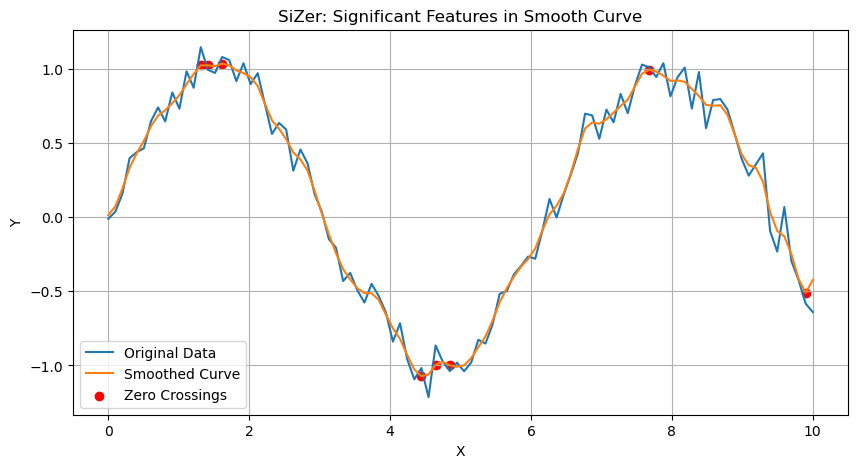

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate some example data
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, size=x.shape)  # Smooth curve with noise

# Smooth the data using a Gaussian kernel
smoothed_y = np.convolve(y, norm.pdf(np.linspace(-2, 2, 5)), mode='same') / np.sum(norm.pdf(np.linspace(-2, 2, 5)))

# Calculate the first derivative of the smoothed curve
dy_dx = np.gradient(smoothed_y, x)

# Identify zero crossings of the first derivative
zero_crossings = np.where(np.diff(np.sign(dy_dx)))[0]

# Plot the original data and the smoothed curve
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Original Data')
plt.plot(x, smoothed_y, label='Smoothed Curve')
plt.scatter(x[zero_crossings], smoothed_y[zero_crossings], color='red', label='Zero Crossings')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('SiZer: Significant Features in Smooth Curve')
plt.legend()
plt.grid(True)
plt.show()


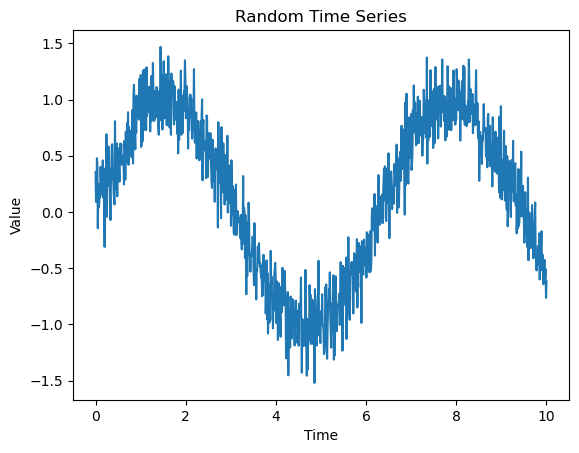

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generating a random time series
np.random.seed(0)  # for reproducibility
n = 1000
x = np.linspace(0, 10, n)
y = np.sin(x) + np.random.normal(scale=0.2, size=n)

# Plotting the time series
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Random Time Series')
plt.show()


In [5]:
import numpy as np
from scipy.stats import linregress

def SiZer(x, y, h=None, x_grid=None, degree=None, derv=1, grid_length=41, quiet=True):
    
    def x_grid_create(x_grid, x, y, grid_length):
        if x_grid is None:
            return np.linspace(np.min(x), np.max(x), grid_length)
        elif isinstance(x_grid, int):
            return np.linspace(np.min(x), np.max(x), x_grid)
        elif len(x_grid) == 2:
            return np.linspace(x_grid[0], x_grid[1], grid_length)
        else:
            return np.array(x_grid)

    def h_grid_create(h, x, y, grid_length):
        if h is None:
            return np.linspace(0.5, 10, grid_length)
        elif isinstance(h, int):
            return np.linspace(0.5, 10, h)
        elif len(h) == 2:
            return np.linspace(h[0], h[1], grid_length)
        else:
            return np.array(h)

    def locally_weighted_polynomial(x, y, h, x_grid, degree):
        y_pred = np.zeros_like(x_grid)
        for i, x0 in enumerate(x_grid):
            weights = np.exp(-(x - x0) ** 2 / (2 * h ** 2))
            X = np.vander(x, degree + 1)
            W = np.diag(weights)
            coef = np.linalg.solve(X.T @ W @ X, X.T @ W @ y)
            y_pred[i] = np.dot(np.vander([x0], degree + 1), coef)
        return y_pred

    def find_states(intervals):
        slopes = np.zeros(len(intervals))
        for i, interval in enumerate(intervals):
            if interval[0] > 0:
                slopes[i] = 1
            elif interval[1] < 0:
                slopes[i] = -1
            else:
                slopes[i] = 0
        return slopes

    x_grid = x_grid_create(x_grid, x, y, grid_length)
    h_grid = h_grid_create(h, x, y, grid_length)

    if degree is None:
        degree = derv + 1

    slopes = np.zeros((len(h_grid), len(x_grid)))
    for i, h in enumerate(h_grid):
        if not quiet:
            print(f"Now calculating h={h}")
        y_pred = locally_weighted_polynomial(x, y, h, x_grid, degree)
        intervals = []
        for j in range(len(x_grid)):
            start = max(0, j - 10)
            end = min(len(x) - 1, j + 10)
            interval = linregress(x[start:end], y_pred[start:end])
            intervals.append((interval.slope - interval.stderr, interval.slope + interval.stderr))
        slopes[i] = find_states(intervals)

    return {"x_grid": x_grid, "h_grid": h_grid, "slopes": slopes}

# Example usage
# x = np.array(...)
# y = np.array(...)
# SiZer_result = SiZer(x, y, h=(0.5, 10), degree=1, derv=1, grid_length=21)
# print(SiZer_result)


In [7]:
SiZer_result = SiZer(x, y, h=(0.5, 10), degree=1, derv=1, grid_length=21)
print(SiZer_result)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 20 and the array at index 1 has size 19

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

def SiZer(x, y, h=None, x_grid=None, degree=None, derv=1, grid_length=41, quiet=True):
    def x_grid_create(x_grid, x, y, grid_length):
        if x_grid is None:
            x_grid = np.linspace(np.min(x), np.max(x), grid_length)
        elif len(x_grid) == 1:
            x_grid = np.linspace(np.min(x), np.max(x), x_grid)
        elif len(x_grid) == 2:
            x_grid = np.linspace(x_grid[0], x_grid[1], grid_length)
        return x_grid

    def h_grid_create(h_grid, x, y, grid_length):
        h_max = np.diff(np.sort(x)).max() * 2
        h_min = np.diff(np.sort(x)).min()
        if h_grid is None:
            h_grid = np.logspace(np.log10(h_min), np.log10(h_max), grid_length)
        elif len(h_grid) == 1:
            h_grid = np.logspace(np.log10(h_min), np.log10(h_max), h_grid)
        elif len(h_grid) == 2:
            h_grid = np.logspace(np.log10(h_grid[0]), np.log10(h_grid[1]), grid_length)
        return h_grid

    def locally_weighted_polynomial(x, y, h, x_grid, degree):
        kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(x[:, np.newaxis])
        log_dens = kde.score_samples(x_grid[:, np.newaxis])
        smoothed_y = np.convolve(y, norm.pdf(x_grid, scale=h) * np.exp(log_dens), mode='same') / \
                      np.convolve(np.ones_like(y), norm.pdf(x_grid, scale=h) * np.exp(log_dens), mode='same')
        return smoothed_y

    def calc_CI_locally_weighted_polynomial(model, derv):
        # Implementation needed based on your specific method

    def find_states(intervals):
        # Implementation needed based on your specific method

        x_grid = x_grid_create(x_grid, x, y, grid_length)
        h_grid = h_grid_create(h, x, y, grid_length)

        if degree is None:
            degree = derv + 1

        slopes = np.zeros((len(h_grid), len(x_grid)))
        for i, h in enumerate(h_grid):
            if not quiet:
                print(f'Now calculating h={h}')
            smoothed_y = locally_weighted_polynomial(x, y, h, x_grid, degree)
            intervals = calc_CI_locally_weighted_polynomial(smoothed_y, derv)
            slopes[i, :] = find_states(intervals)

        return {'x_grid': x_grid, 'h_grid': h_grid, 'slopes': slopes}

def plot_SiZer(x, y_label='log10(h)', colorlist=['red', 'purple', 'blue', 'grey'], ggplot2=False, **kwargs):
    if ggplot2:
        # Implementation needed based on your specific method
        pass
    else:
        slopes = x['slopes']
        final_colorlist = [color for color, value in zip(colorlist, np.unique(slopes)) if str(value) in ['-1', '0', '1', '2']]
        plt.imshow(slopes, extent=[x['x_grid'].min(), x['x_grid'].max(), np.log10(x['h_grid']).min(), np.log10(x['h_grid']).max()], aspect='auto', cmap=plt.get_cmap('viridis'))
        plt.colorbar(label='Class')
        plt.ylabel(y_label)
        plt.xlabel('x')
        plt.title('SiZer Map')
        x_midpoint = np.diff([x['x_grid'].min(), x['x_grid'].max()]) / 2 + x['x_grid'].min()
        for h in x['h_grid']:
            plt.plot([x_midpoint + h, x_midpoint - h], [np.log10(h), np.log10(h)], color='white')
        plt.show()

# Usage examples:
# SiZer_map = SiZer(x, y, h=[0.5, 10], degree=1, derv=1, grid_length=21)
# plot_SiZer(SiZer_map)


IndentationError: expected an indented block (991571325.py, line 38)

IndexError: index 1 is out of bounds for axis 0 with size 1

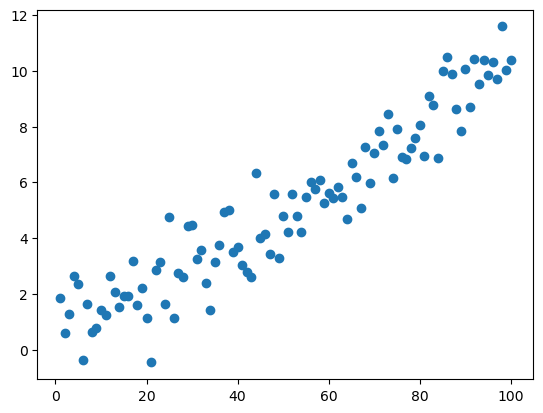

In [4]:
import numpy as np
import statsmodels.api as sm

# Generate random time series data
np.random.seed(0)
time = np.arange(1, 101)
values = np.random.normal(loc=0, scale=1, size=100) + 0.1 * time  # Trend with noise






# Initialize arrays to store results
trend_significance = np.zeros_like(values, dtype=str)  # Stores '+' for positive trend, '-' for negative trend, '0' for no significant trend
p_values = np.zeros_like(values)

# Test each point for trend significance
for i in range(len(values)):
    # Fit linear regression model up to the current point
    X = sm.add_constant(time[:i+1])
    model = sm.OLS(values[:i+1], X)
    results = model.fit()
    
    # Get slope coefficient and p-value
    slope = results.params[1]
    p_value = results.pvalues[1]
    
    # Determine trend significance
    if p_value < 0.05:
        if slope > 0:
            trend_significance[i] = '+'
        elif slope < 0:
            trend_significance[i] = '-'
    else:
        trend_significance[i] = '0'
    
    p_values[i] = p_value

# Print trend significance for each point
for i, trend in enumerate(trend_significance):
    print(f"Time {i+1}: {trend} (p-value: {p_values[i]:.4f})")



Time 1:  (p-value: 0.0000)
Time 2: 0 (p-value: nan)
Time 3: 0 (p-value: 0.6938)
Time 4: 0 (p-value: 0.5520)
Time 5: 0 (p-value: 0.3021)
Time 6: 0 (p-value: 0.6855)
Time 7: 0 (p-value: 0.8123)
Time 8: 0 (p-value: 0.5568)
Time 9: 0 (p-value: 0.4254)
Time 10: 0 (p-value: 0.5140)
Time 11: 0 (p-value: 0.5336)
Time 12: 0 (p-value: 0.8958)
Time 13: 0 (p-value: 0.6662)
Time 14: 0 (p-value: 0.6614)
Time 15: 0 (p-value: 0.5204)
Time 16: 0 (p-value: 0.4136)
Time 17: 0 (p-value: 0.1489)
Time 18: 0 (p-value: 0.1762)
Time 19: 0 (p-value: 0.1228)
Time 20: 0 (p-value: 0.2223)
Time 21: 0 (p-value: 0.8234)
Time 22: 0 (p-value: 0.4931)
Time 23: 0 (p-value: 0.2413)
Time 24: 0 (p-value: 0.2601)
Time 25: 0 (p-value: 0.0646)
Time 26: 0 (p-value: 0.1175)
Time 27: 0 (p-value: 0.0741)
Time 28: 0 (p-value: 0.0506)
Time 29: + (p-value: 0.0137)
Time 30: + (p-value: 0.0036)
Time 31: + (p-value: 0.0018)
Time 32: + (p-value: 0.0007)
Time 33: + (p-value: 0.0008)
Time 34: + (p-value: 0.0027)
Time 35: + (p-value: 0.0015

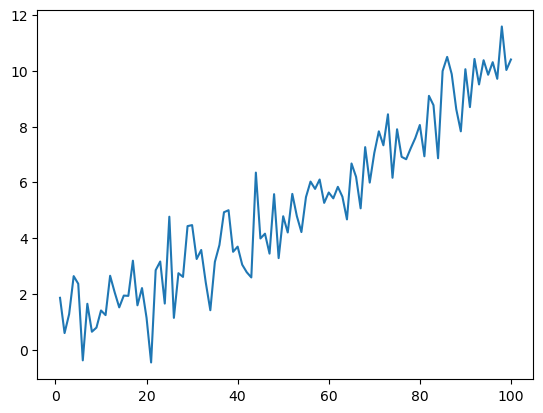

In [6]:
import numpy as np
import statsmodels.api as sm

# Generate random time series data
np.random.seed(0)
time = np.arange(1, 101)
values = np.random.normal(loc=0, scale=1, size=100) + 0.1 * time  # Trend with noise


# plot the data
import matplotlib.pyplot as plt
plt.plot(time, values)


# Initialize arrays to store results
trend_significance = np.zeros_like(values, dtype=str)  # Stores '+' for positive trend, '-' for negative trend, '0' for no significant trend
p_values = np.zeros_like(values)

# Test each point for trend significance
for i in range(len(values)):
    if i == 0:  # Skip the first point as we can't fit a regression model with only one point
        continue
    
    # Fit linear regression model up to the current point
    X = sm.add_constant(time[:i+1])
    model = sm.OLS(values[:i+1], X)
    try:
        results = model.fit()
    except np.linalg.LinAlgError:
        continue
    
    # Get slope coefficient and p-value
    slope = results.params[1]
    p_value = results.pvalues[1]
    
    # Determine trend significance
    if p_value < 0.05:
        if slope > 0:
            trend_significance[i] = '+'
        elif slope < 0:
            trend_significance[i] = '-'
    else:
        trend_significance[i] = '0'
    
    p_values[i] = p_value

# Print trend significance for each point
for i, trend in enumerate(trend_significance):
    print(f"Time {i+1}: {trend} (p-value: {p_values[i]:.4f})")


2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89
90 90
91 91
92 92
93 93
94 94
95 95
96 96
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78


ValueError: x and y must have same first dimension, but have shapes (97,) and (96,)

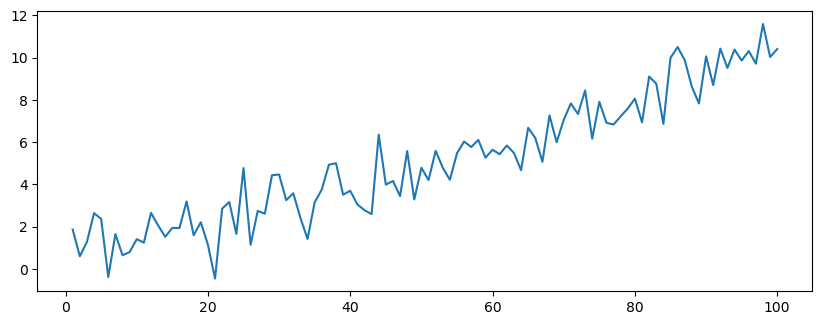

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Generate random time series data
np.random.seed(0)
time = np.arange(1, 101)
values = np.random.normal(loc=0, scale=1, size=100) + 0.1 * time  # Trend with noise

# Define smoothing lengths
smoothing_lengths = np.arange(5, 31, 5)

# Initialize arrays to store results
trend_significance = np.zeros((len(smoothing_lengths), len(values)), dtype=str)  # Stores '+' for positive trend, '-' for negative trend, '0' for no significant trend
p_values = np.zeros((len(smoothing_lengths), len(values)))

# Test each point for trend significance for original and smoothed versions
for i, length in enumerate(smoothing_lengths):
    smoothed_values = np.convolve(values, np.ones(length)/length, mode='valid')
    time_smoothed = np.arange(length//2 + 1, len(values) - length//2 + 1)
    
    for j in range(len(smoothed_values)):
        if j == 0:  # Skip the first point as we can't fit a regression model with only one point
            continue
        
        # Fit linear regression model up to the current point
        X = time_smoothed[:j+1]
        y = smoothed_values[:j+1]

        # prin the length of x and y
        print(len(X), len(y))

#         model = sm.OLS(y, X)
#         try:
#             results = model.fit()
#         except np.linalg.LinAlgError:
#             continue

#         # Get slope coefficient and p-value
#         slope = results.params
#         p_value = results.pvalues

#         # Determine trend significance
#         if p_value < 0.05:
#             if slope > 0:
#                 trend_significance[i, j] = '+'
#             elif slope < 0:
#                 trend_significance[i, j] = '-'
#         else:
#             trend_significance[i, j] = '0'

#         p_values[i, j] = p_value

# Plot original time series and smoothed versions
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(time, values, label='Original Time Series')
for i, length in enumerate(smoothing_lengths):
    plt.plot(time[length//2:len(values) - length//2 + 1], np.convolve(values, np.ones(length)/length, mode='valid'), label=f'Smoothed (Length={length})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# # Create 2D colormap plot for trend significance
# plt.subplot(2, 1, 2)
# plt.imshow(np.flipud(MinMaxScaler().fit_transform(np.where(trend_significance == '+', 1, np.where(trend_significance == '-', -1, 0)))), cmap='coolwarm', aspect='auto')
# plt.xlabel('Time')
# plt.ylabel('log(Smoothing Length)')
# plt.yticks(np.arange(len(smoothing_lengths)), np.log(smoothing_lengths))
# plt.colorbar(label='Trend Significance')
# plt.tight_layout()
# plt.show()


100
100
100
100
100
100
100
100
100
100


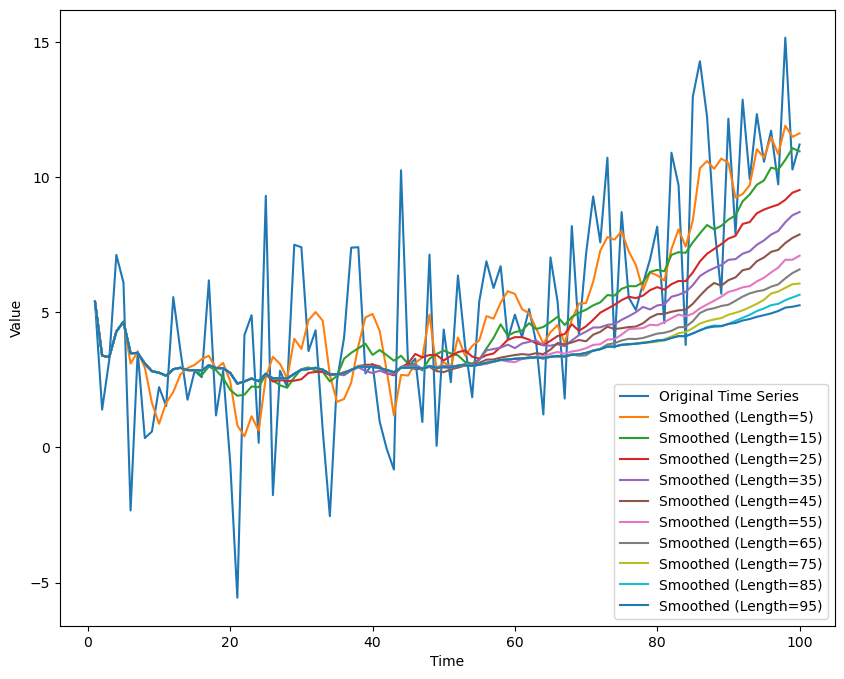

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate random time series data
np.random.seed(0)
time = np.arange(1, 101)
values = np.random.normal(loc=0, scale=3, size=100) + 0.1 * time  # Trend with noise

# Define smoothing lengths
smoothing_lengths = np.arange(5, 101, 10)

# Initialize arrays to store results
smoothed_values_all = []

# Perform smoothing for each length
for length in smoothing_lengths:
    # Perform moving average smoothing using rolling function
    smoothed_values = pd.Series(values).rolling(window=length, min_periods=1).mean().values

    # print the length of smoothed values
    print(len(smoothed_values))
    
    # Store smoothed values
    smoothed_values_all.append(smoothed_values)

# Plot original time series and smoothed versions
plt.figure(figsize=(10, 8))
plt.plot(time, values, label='Original Time Series')
for i, length in enumerate(smoothing_lengths):
    plt.plot(time, smoothed_values_all[i], label=f'Smoothed (Length={length})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


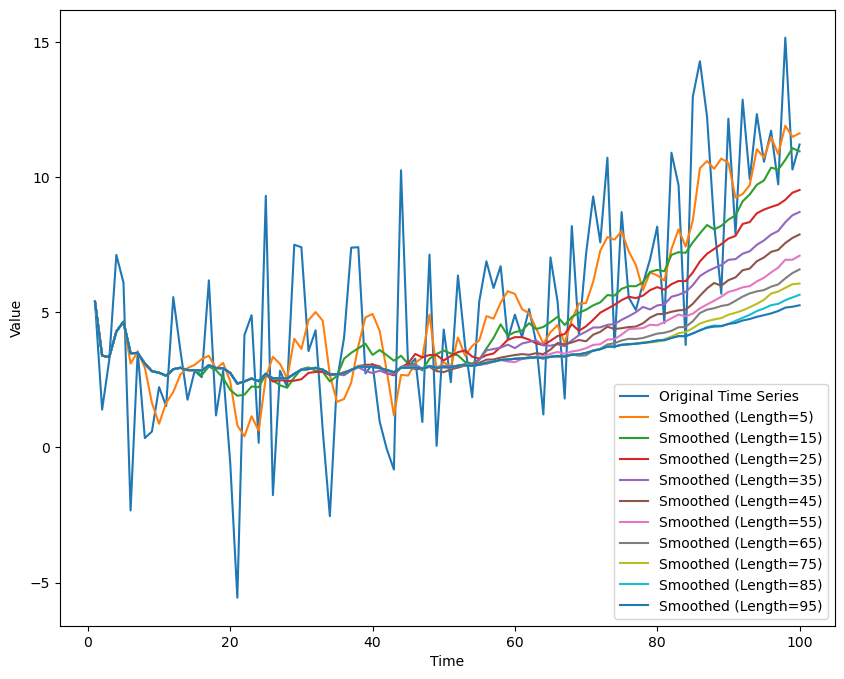

TypeError: Image data of dtype <U1 cannot be converted to float

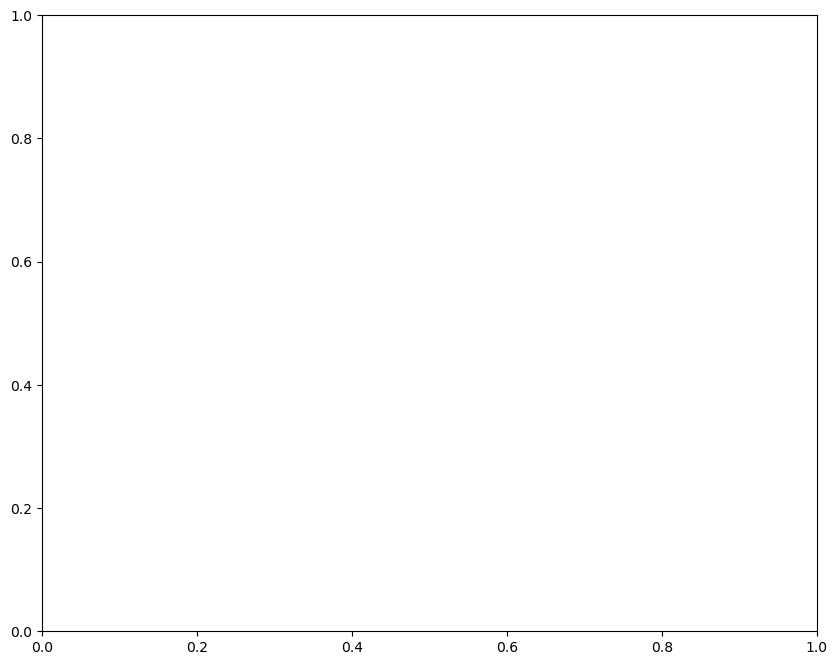

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import t

# Generate random time series data
np.random.seed(0)
time = np.arange(1, 101)
values = np.random.normal(loc=0, scale=3, size=100) + 0.1 * time  # Trend with noise

# Define smoothing lengths
smoothing_lengths = np.arange(5, 101, 10)

# Initialize arrays to store results
smoothed_values_all = []
trend_significance_all = []

# Perform smoothing for each length
for length in smoothing_lengths:
    # Perform moving average smoothing using rolling function
    smoothed_values = pd.Series(values).rolling(window=length, min_periods=1).mean().values

    # Fit linear regression model to calculate trend
    X = time.reshape(-1, 1)
    y = smoothed_values
    model = LinearRegression()
    model.fit(X, y)

    # Calculate residuals
    residuals = y - model.predict(X)

    # Calculate standard error of the slope
    mse = np.sum(residuals ** 2) / (len(X) - 2)
    se_slope = np.sqrt(mse / np.sum((X - np.mean(X)) ** 2))

    # Calculate t-value for the slope
    t_value = model.coef_[0] / se_slope

    # Calculate p-value
    p_value = 2 * (1 - t.cdf(np.abs(t_value), len(X) - 2))

    # Determine trend significance
    if p_value < 0.05:
        if model.coef_[0] > 0:
            trend_significance_all.append('+')
        elif model.coef_[0] < 0:
            trend_significance_all.append('-')
    else:
        trend_significance_all.append('0')

    # Store smoothed values
    smoothed_values_all.append(smoothed_values)

# Plot original time series and smoothed versions
plt.figure(figsize=(10, 8))
plt.plot(time, values, label='Original Time Series')
for i, length in enumerate(smoothing_lengths):
    plt.plot(time, smoothed_values_all[i], label=f'Smoothed (Length={length})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot 2D color map for trend significance
plt.figure(figsize=(10, 8))
plt.imshow(np.flipud(np.array(trend_significance_all).reshape(len(smoothing_lengths), -1)), cmap='coolwarm', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Smoothing Length')
plt.xticks(ticks=np.arange(len(time))[::10], labels=time[::10])
plt.yticks(ticks=np.arange(len(smoothing_lengths)), labels=smoothing_lengths)
plt.colorbar(label='Trend Significance')
plt.show()


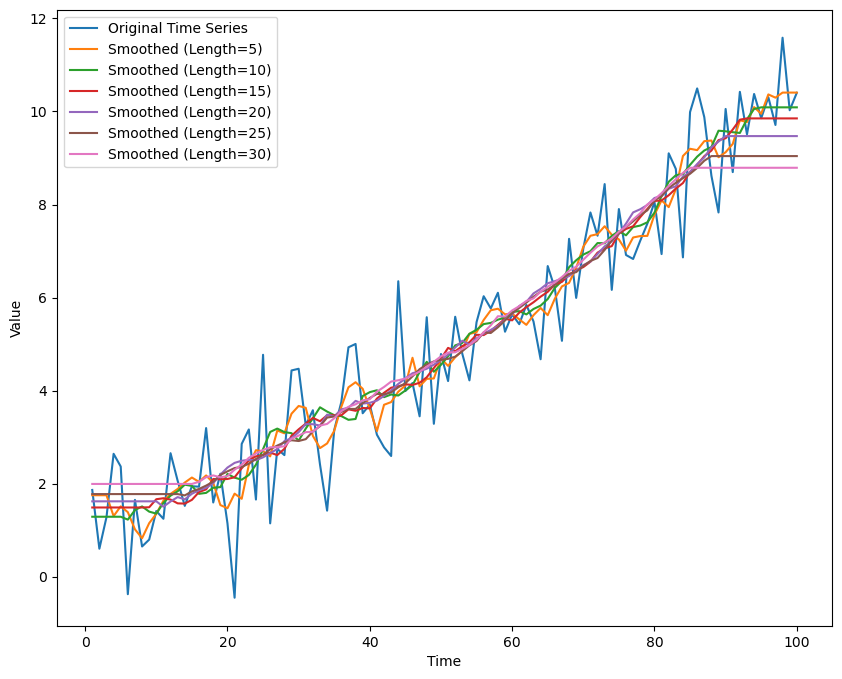

In [18]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Generate random time series data
np.random.seed(0)
time = np.arange(1, 101)
values = np.random.normal(loc=0, scale=1, size=100) + 0.1 * time  # Trend with noise

# Define smoothing lengths
smoothing_lengths = np.arange(5, 31, 5)

# Initialize arrays to store results
smoothed_values_all = []

# Perform smoothing for each length
for length in smoothing_lengths:
    # Perform moving average smoothing
    smoothed_values = np.convolve(values, np.ones(length)/length, mode='valid')
    
    # Pad the unsmoothed points at the edges to match the original data length
    pad_left = (length - 1) // 2
    pad_right = length // 2
    smoothed_values = np.concatenate((np.full(pad_left, smoothed_values[0]), smoothed_values, np.full(pad_right, smoothed_values[-1])))
    
    # Store smoothed values
    smoothed_values_all.append(smoothed_values)

# Plot original time series and smoothed versions
plt.figure(figsize=(10, 8))
plt.plot(time, values, label='Original Time Series')
for i, length in enumerate(smoothing_lengths):
    plt.plot(time, smoothed_values_all[i], label=f'Smoothed (Length={length})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89
90 90
91 91
92 92
93 93
94 94
95 95
96 96
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78


ValueError: x and y must have same first dimension, but have shapes (97,) and (96,)

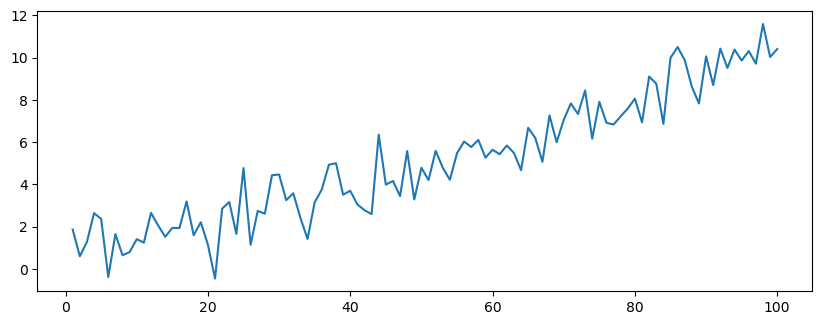

In [17]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Generate random time series data
np.random.seed(0)
time = np.arange(1, 101)
values = np.random.normal(loc=0, scale=1, size=100) + 0.1 * time  # Trend with noise

# Define smoothing lengths
smoothing_lengths = np.arange(5, 31, 5)

# Initialize arrays to store results
trend_significance = np.zeros((len(smoothing_lengths), len(values)), dtype=str)  # Stores '+' for positive trend, '-' for negative trend, '0' for no significant trend
p_values = np.zeros((len(smoothing_lengths), len(values)))

# Test each point for trend significance for original and smoothed versions
for i, length in enumerate(smoothing_lengths):
    smoothed_values = np.convolve(values, np.ones(length)/length, mode='valid')
    time_smoothed = np.arange(length//2 + 1, len(values) - length//2 + 1)
    
    for j in range(len(smoothed_values)):
        if j == 0:  # Skip the first point as we can't fit a regression model with only one point
            continue
        
        # Fit linear regression model up to the current point
        X = time_smoothed[:j+1]
        y = smoothed_values[:j+1]

        # prin the length of x and y
        print(len(X), len(y))

#         model = sm.OLS(y, X)
#         try:
#             results = model.fit()
#         except np.linalg.LinAlgError:
#             continue

#         # Get slope coefficient and p-value
#         slope = results.params
#         p_value = results.pvalues

#         # Determine trend significance
#         if p_value < 0.05:
#             if slope > 0:
#                 trend_significance[i, j] = '+'
#             elif slope < 0:
#                 trend_significance[i, j] = '-'
#         else:
#             trend_significance[i, j] = '0'

#         p_values[i, j] = p_value

# Plot original time series and smoothed versions
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(time, values, label='Original Time Series')
for i, length in enumerate(smoothing_lengths):
    plt.plot(time[length//2:len(values) - length//2 + 1], np.convolve(values, np.ones(length)/length, mode='valid'), label=f'Smoothed (Length={length})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# # Create 2D colormap plot for trend significance
# plt.subplot(2, 1, 2)
# plt.imshow(np.flipud(MinMaxScaler().fit_transform(np.where(trend_significance == '+', 1, np.where(trend_significance == '-', -1, 0)))), cmap='coolwarm', aspect='auto')
# plt.xlabel('Time')
# plt.ylabel('log(Smoothing Length)')
# plt.yticks(np.arange(len(smoothing_lengths)), np.log(smoothing_lengths))
# plt.colorbar(label='Trend Significance')
# plt.tight_layout()
# plt.show()
